In [1]:
%matplotlib inline
from matplotlib import rcParams
import matplotlib.pyplot as plt

# Introduction to Ensemble Methods

Ensemble methods are techniques for obtaining better predictive performances by using multiple models.

To get an overview of the methods we are going to see today, you can watch this video of Machine learnia about Ensemble learning : https://www.youtube.com/watch?v=7C_YpudYtw8 (you don't need to understand everything before beginning the notebook ;)).

The following dataset comes from a bank which would like to know when a new client arrives if this client will subscribe to a long term deposit.

The bank will be considered as your client in the following parts.

---

**Feel free to create sklearn Pipelines for simplifying the following experiments** 

## Introducing and exploring the dataset

The dataset is located in `../data/bank-full.csv`. It has 17 columns, the target column or $ŷ$ is the column named `y`.

Columns summary  : 

| column name | simple description |
|-------------|------------------------|
| age | age |
| job | type of job |
| marital | marital status |
| education | education level |
| default | has credit in default? |
| balance | average yearly balance, in euros  |
| housing | has housing loan? |
| loan | has personal loan? |
| contact | contact communication |
| month | last contact month of year |
| day_of_week | last contact day of the week |
| duration |  last contact duration in seconds |
| campaign |  number of contacts performed during campaign for this client |
| pday | number of days that passed by after the client was last contacted from a previous campaign (-1 means client was not previously contacted) |
| previous | number of contacts performed before this campaign and for this client |
| poutcome | outcome of the previous marketing campaign |
| **output :** |  |
| y | has  the client subscribed a term deposit? |

Let's explore the dataset a bit using pandas.

While exploring the dataset it is recommended to create a list of categorical features

In [2]:
import pandas as pd
import numpy as np

Create a dataframe with the dataset `../data/bank-full.csv`

In [3]:
# code here
dfall = pd.read_csv('../data/bank-full.csv',sep=";")

Describe the dataset informations

In [4]:
dfall.describe()
dfall.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


Use histogramms to display the features' distribution

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y'],
      dtype='object')

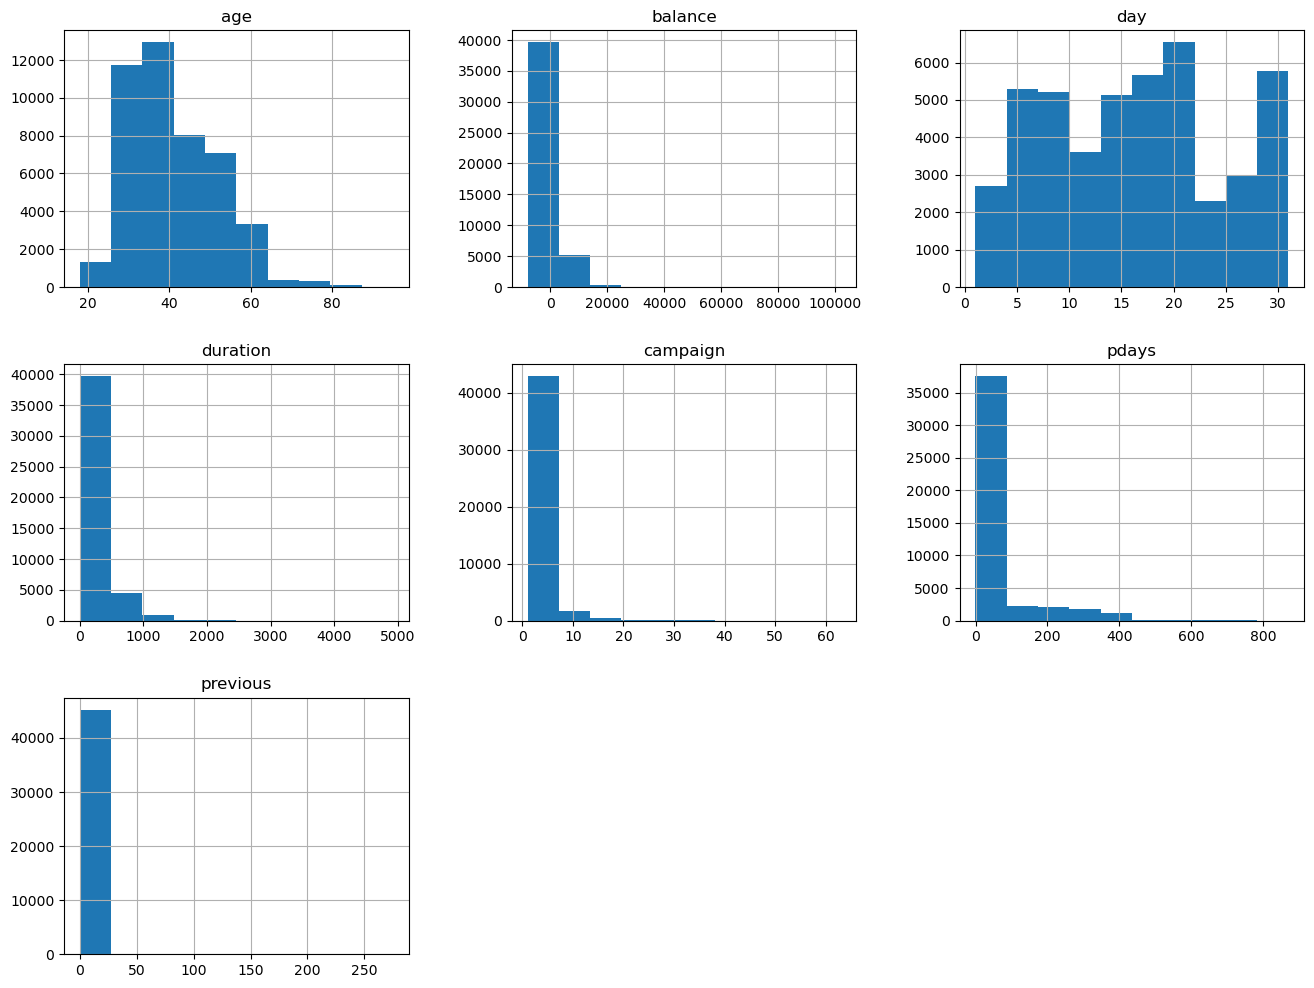

In [5]:
rcParams['figure.figsize'] = 16,12
plots = dfall.hist()
dfall.columns

Use heatmap to display the numerical features' correlation

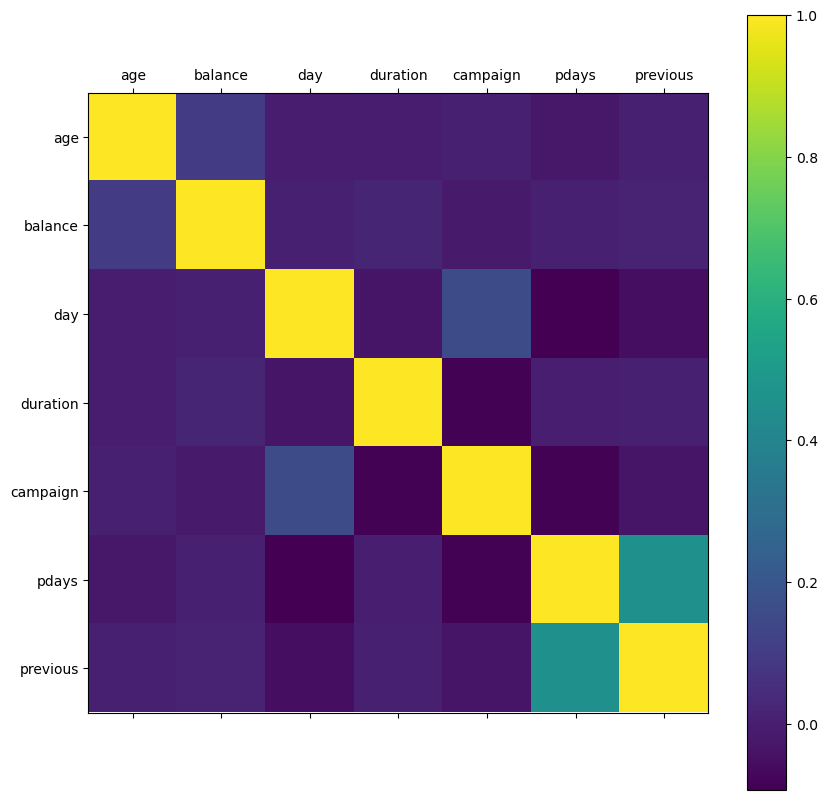

In [7]:
# code here
numerical_features=['age', 'balance', 'day', 'duration', 'campaign', 'pdays','previous']
dfall_num=dfall[numerical_features]
rcParams['figure.figsize'] = 14, 10
plt.matshow(dfall_num.corr())
plt.yticks(np.arange(dfall_num.shape[1]), dfall_num.columns)
plt.xticks(np.arange(dfall_num.shape[1]), dfall_num.columns)
plt.colorbar()


Hop hop hop!!! Not to fast!! Before processing data for machine learning, do you think that all the data are useful?  
As an expert, I tell you you should removed the duration column!!

Could you tell me why?
'

In [8]:
from rich.console import Console
console = Console()
console.print("La colonne duration est le temps d'appel!", style="bold yellow")
console.print("Le but est de prédire si le client a déposé un recours. Forcément la durée d'appel sera plus long lors d'un dépot", style="bold yellow")
console.print("Par conséquent la varibale duration est trés corrélée avec la variable cible y que l'on veut prédire", style="bold yellow")

dfall.duration.describe()
# Utilisation

La colonne duration est le temps d'appel!

Le but est de prédire si le client a déposé un recours. Forcément la durée d'appel sera plus long lors d'un dépot

Par conséquent la varibale duration est trés corrélée avec la variable cible y que l'on veut prédire

count    45211.000000
mean       258.163080
std        257.527812
min          0.000000
25%        103.000000
50%        180.000000
75%        319.000000
max       4918.000000
Name: duration, dtype: float64

💡*think first, but if you have no idea double click here.*
<!-- When do your calls last the most? --> 

In [9]:
# remove duration column
df=dfall.copy()
df=df.drop("duration", axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  campaign   45211 non-null  int64 
 12  pdays      45211 non-null  int64 
 13  previous   45211 non-null  int64 
 14  poutcome   45211 non-null  object
 15  y          45211 non-null  object
dtypes: int64(6), object(10)
memory usage: 5.5+ MB


The date is a strange type of data for machine learning. Think about it. Is the day? the month? the year that are important? Or the relative date for instance in the year?

If the phenomenon occurs seasonally, maybe it is better to look at the day of the year (on 365 days), if it monthly, maybe to look at the day in the month (on approximativally 30, 31 or other for bissextile year), etc... If more complex, well do the proper hypothesis and test it.

For our problem, we supposed it is better to look at the day of the year. Maybe it is a good hypothesis, maybe not. It is an hypothesis we want you to test. So in order to continue the preprocessing, the features `day` and `month` should be merged into one column named `dayoftheyear`. 

You can use pandas datetime tools or python **datetime** librairies for doing this preprocessing. To find the the day of year, look as *dayofyear* method from **datetime** library and examples such as https://pythonguides.com/extract-day-number-of-the-year-from-a-date-in-python/ or https://docs.lucee.org/reference/functions/dayofyear.html
(the default year used will be 1984)

In [10]:
df.day.describe()
df.month.unique()

array(['may', 'jun', 'jul', 'aug', 'oct', 'nov', 'dec', 'jan', 'feb',
       'mar', 'apr', 'sep'], dtype=object)

In [11]:
#code here
# You can concatenate multiple Series containing string by just summing them.
# However, be sure each Serie contains string, in case use .astype(str)
import datetime as dt
month_map = {
    'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6,
    'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12
}
df['month_num'] = df['month'].map(month_map)
df['date'] = pd.to_datetime(dict(year=2024, month=df['month_num'], day=df['day'])) ## on suppose 'alnnée 2024, cela n'est pas spécifié dans le jeu de données, pas de vraible année

# Extraction du jour dans l’année
df['dayoftheyear'] = df['date'].dt.dayofyear

df.dayoftheyear.unique()

df.drop(columns=['month_num','date','day','month'],inplace=True)
df.info()
df.dayoftheyear.describe()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   age           45211 non-null  int64 
 1   job           45211 non-null  object
 2   marital       45211 non-null  object
 3   education     45211 non-null  object
 4   default       45211 non-null  object
 5   balance       45211 non-null  int64 
 6   housing       45211 non-null  object
 7   loan          45211 non-null  object
 8   contact       45211 non-null  object
 9   campaign      45211 non-null  int64 
 10  pdays         45211 non-null  int64 
 11  previous      45211 non-null  int64 
 12  poutcome      45211 non-null  object
 13  y             45211 non-null  object
 14  dayoftheyear  45211 non-null  int32 
dtypes: int32(1), int64(5), object(9)
memory usage: 5.0+ MB


count    45211.000000
mean       172.109044
std         74.763073
min          6.000000
25%        130.000000
50%        156.000000
75%        218.000000
max        366.000000
Name: dayoftheyear, dtype: float64

We cannot treat the same way categories with numerical features. So let's make two different lists and different treatments. 

Now sort the features into categorical and numerical features

In [12]:
df.education.unique()

array(['tertiary', 'secondary', 'unknown', 'primary'], dtype=object)

In [13]:
## initiation du pipeline preprocessing

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, FunctionTransformer



# Colonnes à traiter
num_cols = ['age', 'balance', 'campaign', 'pdays','previous','dayoftheyear']
cat_cols = ['job','marital', 'default', 'housing','loan', 'contact', 'poutcome']
cat_ordinal=['education']
cat_nominal = [c for c in cat_cols if c not in cat_ordinal] ## si catégories nominal

# Pipelines pour chaque type
num_pipeline = Pipeline([
    ('NumImputer', SimpleImputer(strategy='median')), ## imputer est nom qu'on donne pour s'y retrouver
    ('scaler', StandardScaler())   ### idem pour scaler
])

cat_pipelineOrd = Pipeline([
    ('CatImputer', SimpleImputer(strategy='most_frequent')),
    ('CatencoderOrd', OrdinalEncoder(handle_unknown="use_encoded_value",unknown_value=-1))
])

cat_pipelineOne = Pipeline([
    ('CatImputer', SimpleImputer(strategy='most_frequent')),
    ('CatencoderOne', OneHotEncoder(handle_unknown="infrequent_if_exist",
                                    min_frequency=0.01,
                                    sparse_output=True)) ### gestion des rares/inconnues
])

# Fusion dans un seul transformateur
preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_cols),
    ('catOrd', cat_pipelineOrd, cat_ordinal),
    ('catOne', cat_pipelineOne, cat_nominal),   
], remainder='drop')  ### remainder permet de supprimer les autres variables non mentionnés (mettre 'passthrough' si on veut les conservées telles quelles)



After a first exploration, categorical/ordinal features (8 columns) need to be encoded in order to become a valid input for the modeling phase. ML manipulates figures, not string, not category by itself.

Look at the encoder to *encode* your *categorical data*. The different encoders can be found [here](https://scikit-learn.org/stable/api/sklearn.preprocessing.html).

(You can also use the function `gethg_dummies` of pandas for categorical features)

In [14]:
# Create the X and y DataFrames resample the dataframes if necessary
from sklearn.model_selection import train_test_split

X = df.drop(columns=['y'])

# Nettoyage défensif + mapping
y = (df['y']
       .astype(str).str.strip().str.lower()
       .map({'no': 0, 'yes': 1})
       .astype('int8'))

# train_test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [15]:
# import and create the appropriate transformers 
preprocessor.fit(X)

feature_names = preprocessor.get_feature_names_out()
print(len(feature_names), "features")
print(feature_names[:20])  # aperçu


35 features
['num__age' 'num__balance' 'num__campaign' 'num__pdays' 'num__previous'
 'num__dayoftheyear' 'catOrd__education' 'catOne__job_admin.'
 'catOne__job_blue-collar' 'catOne__job_entrepreneur'
 'catOne__job_housemaid' 'catOne__job_management' 'catOne__job_retired'
 'catOne__job_self-employed' 'catOne__job_services' 'catOne__job_student'
 'catOne__job_technician' 'catOne__job_unemployed'
 'catOne__job_infrequent_sklearn' 'catOne__marital_divorced']


At the end of this part, two dataframes are created :

- `X` containing the features (or the matrix $X$)
- `y` containing the label (or $ŷ$)

Well done! The data is now ready to be splitted into sets and used to train models!

## Modelling phase

The client needs two features :

1. A model, which can be updated without performance loss. In other word, it means a pipeline easy to use and evaluate.
2. A model, that performs well.

In [16]:
import numpy as np

def scores_table(scores: dict, model_name: str = "Model", digits: int = 4) -> str:
    """
    Formate un tableau avec Accuracy, Precision, Recall, F1, ROC AUC
    à partir d'un dict 'scores' retourné par cross_validate (avec return_train_score=True)
    ou d'un dict cv_results_ de GridSearchCV.
    """
    metrics = [
        ("Accuracy", "accuracy"),
        ("Precision", "precision"),
        ("Recall", "recall"),
        ("F1 Score", "f1"),
        ("ROC AUC", "roc_auc"),
    ]

    def _mean_or_none(key: str):
        if key in scores:
            val = scores[key]
            try:
                return float(np.mean(val))
            except Exception:
                return float(val)
        return None

    def _get(split: str, mkey: str):
        # cross_validate -> 'train_f1' / 'test_f1'
        # GridSearchCV    -> 'mean_train_f1' / 'mean_test_f1'
        for k in (f"{split}_{mkey}", f"mean_{split}_{mkey}"):
            v = _mean_or_none(k)
            if v is not None:
                return v
        return None

    def _fmt(x):
        return f"{x:.{digits}f}" if x is not None else "-"

    title = f"--- Résultats pour le modèle : {model_name} ---"
    header = "Métrique   | Train    | Test"
    bar = "-" * max(len(title), len(header))

    lines = [title, header, bar]
    for label, key in metrics:
        tr = _get("train", key)
        te = _get("test",  key)
        lines.append(f"{label:<10} | {_fmt(tr):>8} | {_fmt(te):>8}")
    lines.append(bar)
    return "\n".join(lines)

### Dummy Classifier

It is always a good idea to begin with a dummy model as a baseline

In [17]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import StratifiedKFold, cross_validate

modelDummy = Pipeline([
    ('preprocessing', preprocessor),
    ('Regressor', DummyClassifier(strategy="most_frequent",random_state=42))
])

modelDummy.fit(X_train, y_train)
y_predTestDummy = modelDummy.predict(X_test)
y_predTrainDummy = modelDummy.predict(X_train)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoresDummy = cross_validate(
    modelDummy, X, y,
    scoring = {'accuracy':'accuracy','precision':'precision','recall':'recall','f1':'f1','roc_auc':'roc_auc'},
    cv=cv, n_jobs=-1, return_train_score=True
)

print(scores_table(scoresDummy, model_name="Dummy Model"))

pos_rate = np.mean(y)           # si y ∈ {0,1} avec 1="yes"
print("Taux de 'yes' :", pos_rate)         # ~ 0.117 attendu

console.print("Ces scores sont exactement ceux qu’on attend d’un DummyClassifier(strategy='most_frequent') sur un jeu très déséquilibré \n"
              "F1 = 0.000 → le modèle ne prédit jamais la classe positive (1 / “yes”). Du coup precision=0 ou recall=0, donc F1=0.\n"
              "Cela se voit sur le taux de yes => 0.117"
              "Accuracy ≈ 0.883 → il se contente de prédire toujours la classe majoritaire (“no”). L’accuracy égale donc la proportion de la classe majoritaire ≈ 88.3 % (utile comme baseline).\n"
              "ROC AUC = 0.500 → pouvoir discriminant nul (équivalent au hasard). Normal : les scores/probas sont constants.\n"
              "L’écart-type ± 0.000 vient du fait que le modèle est déterministe et que la stratification garde des proportions quasi identiques à chaque fold.\n"
              , style="yellow")




--- Résultats pour le modèle : Dummy Model ---
Métrique   | Train    | Test
----------------------------------------------
Accuracy   |   0.8830 |   0.8830
Precision  |   0.0000 |   0.0000
Recall     |   0.0000 |   0.0000
F1 Score   |   0.0000 |   0.0000
ROC AUC    |   0.5000 |   0.5000
----------------------------------------------
Taux de 'yes' : 0.11698480458295547


Ces scores sont exactement ceux qu’on attend d’un DummyClassifier(strategy='most_frequent') sur un jeu très 
déséquilibré 
F1 = 0.000 → le modèle ne prédit jamais la classe positive (1 / “yes”). Du coup precision=0 ou recall=0, donc F1=0.
Cela se voit sur le taux de yes => 0.117Accuracy ≈ 0.883 → il se contente de prédire toujours la classe majoritaire
(“no”). L’accuracy égale donc la proportion de la classe majoritaire ≈ 88.3 % (utile comme baseline).
ROC AUC = 0.500 → pouvoir discriminant nul (équivalent au hasard). Normal : les scores/probas sont constants.
L’écart-type ± 0.000 vient du fait que le modèle est déterministe et que la stratification garde des proportions 
quasi identiques à chaque fold.

### Simple Decision Tree

We will experiment both feature by doing the two following steps.

* Training the Decision Tree model with various splits of the dataset (change the `seed` parameter of the `train_test_split` function for obtaining the second dataset)
* The decision tree `max_depth` will be fixed at 3 first

if you need more info you can take a look at the [sklearn decision tree doc](https://scikit-learn.org/stable/modules/tree.html).

--- Résultats pour le modèle : Model Decision Tree, Seed = 42 ---
Métrique   | Train    | Test
-----------------------------------------------------------------
Accuracy   |   0.8933 |   0.8924
Precision  |   0.6767 |   0.6607
Recall     |   0.1702 |   0.1654
F1 Score   |   0.2714 |   0.2639
ROC AUC    |   0.6814 |   0.6812
-----------------------------------------------------------------


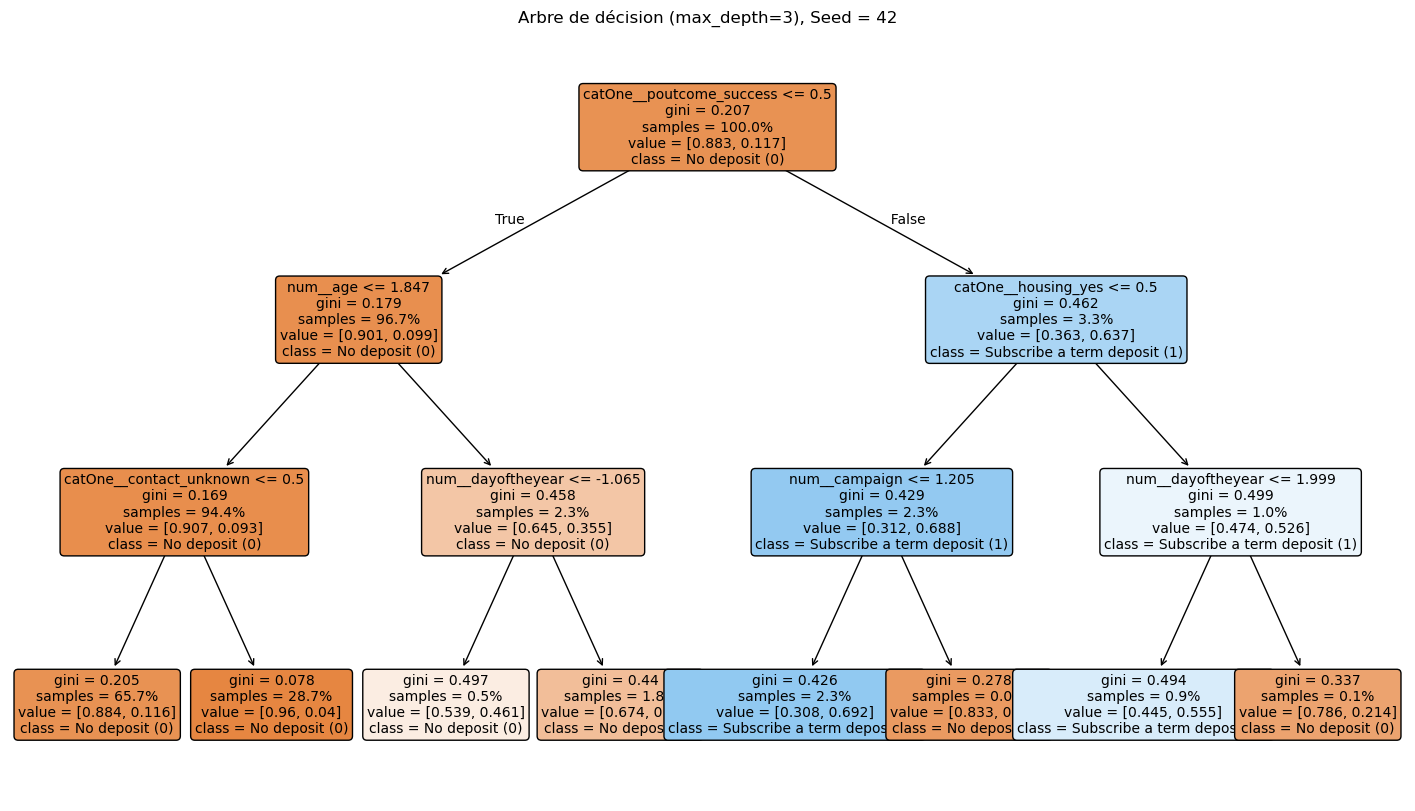

In [118]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, plot_tree


modelCLF = Pipeline([
    ('preprocessing', preprocessor),
    ('Regressor', DecisionTreeClassifier(max_depth=3,random_state=42))
])


modelCLF.fit(X_train, y_train)
y_predTestCLF = modelCLF.predict(X_test)
y_predTrainCLF = modelCLF.predict(X_train)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoresCLF42 = cross_validate(
    modelCLF, X, y,
    scoring= {'accuracy':'accuracy','precision':'precision','recall':'recall','f1':'f1','roc_auc':'roc_auc'},
    cv=cv, n_jobs=-1, return_train_score=True
)


print(scores_table(scoresCLF42, model_name="Model Decision Tree, Seed = 42"))

##### visulatisation de l'arbre de décision
# 1) Récupérer l'arbre entraîné (dernier step du pipeline)
clf = modelCLF.named_steps['Regressor']  # <- c'est un DecisionTreeClassifier

# 2) Récupérer les noms de features après le ColumnTransformer
try:
    feature_names = modelCLF.named_steps['preprocessing'].get_feature_names_out()
except AttributeError:
    # Si jamais pas dispo (vieille version sklearn), on met des noms génériques
    n_features = clf.n_features_in_
    feature_names = np.array([f"feat_{i}" for i in range(n_features)])

# 3) Noms de classes alignés avec l'ordre appris par le modèle
class_names = [ "No deposit (0)", "Subscribe a term deposit (1)" ]

# 4) Visualisation de l'arbre
plt.figure(figsize=(18, 10))
plot_tree(
    clf,
    feature_names=feature_names,
    class_names=class_names,
    filled=True,
    rounded=True,
    proportion=True,   # affiche les proportions dans les nœuds
    fontsize=10
)
plt.title("Arbre de décision (max_depth=3), Seed = 42")
plt.show()



Now, a first model has been created, change the random seed for the train/test split, and create another tree.

This tree should be created with the same hyperparameters than above. 

--- Résultats pour le modèle : Model Decision Tree, Seed = 64 ---
Métrique   | Train    | Test
-----------------------------------------------------------------
Accuracy   |   0.8935 |   0.8924
Precision  |   0.6681 |   0.6513
Recall     |   0.1792 |   0.1730
F1 Score   |   0.2824 |   0.2733
ROC AUC    |   0.6815 |   0.6805
-----------------------------------------------------------------


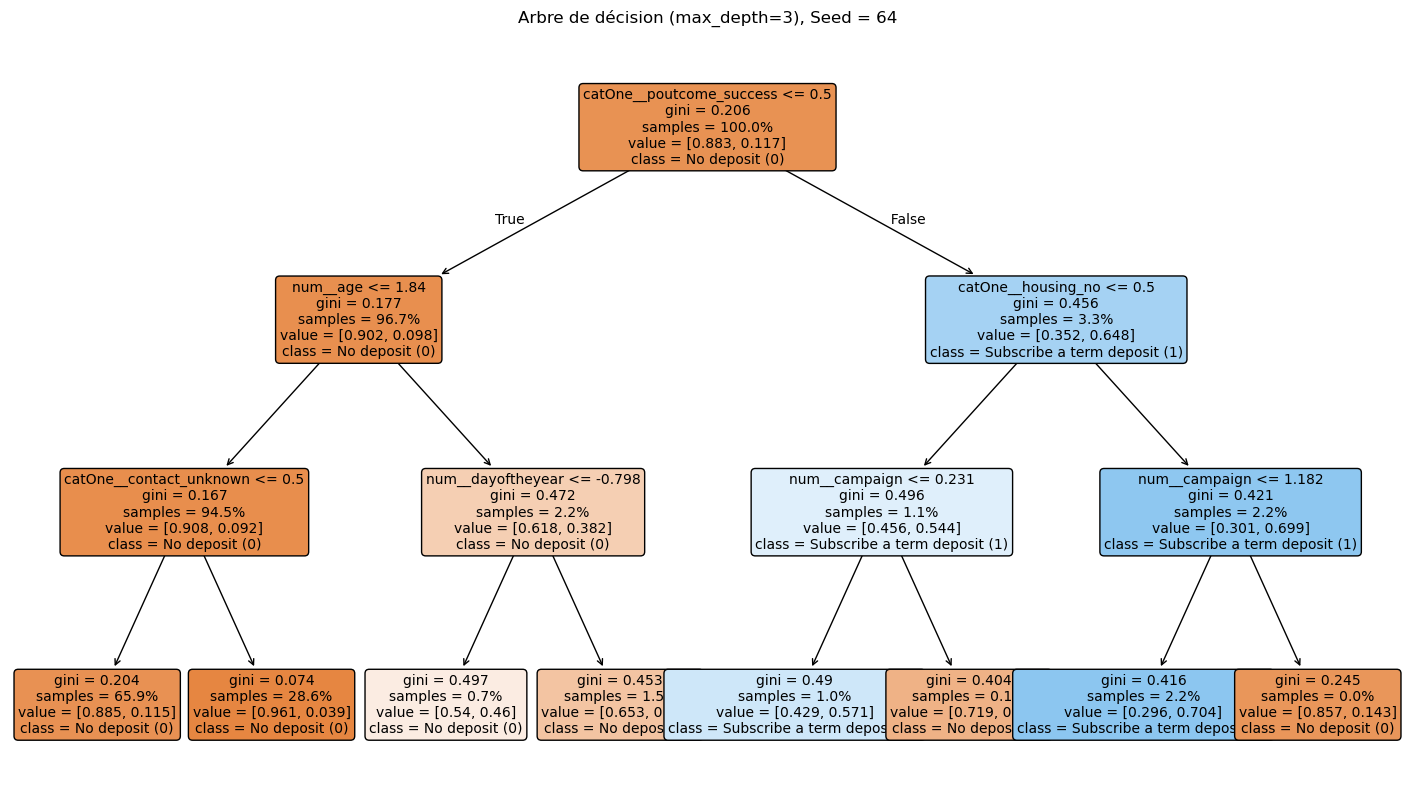

In [19]:
# create a new train and test dataset with a different seed
modelCLF = Pipeline([
    ('preprocessing', preprocessor),
    ('Regressor', DecisionTreeClassifier(max_depth=3,random_state=64))
])


modelCLF.fit(X_train, y_train)
y_predTestCLF = modelCLF.predict(X_test)
y_predTrainCLF = modelCLF.predict(X_train)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=64)
scoresCLF = cross_validate(
    modelCLF, X, y,
    scoring= {'accuracy':'accuracy','precision':'precision','recall':'recall','f1':'f1','roc_auc':'roc_auc'},
    cv=cv, n_jobs=-1, return_train_score=True
)


print(scores_table(scoresCLF, model_name="Model Decision Tree, Seed = 64"))

##### visulatisation de l'arbre de décision
# 1) Récupérer l'arbre entraîné (dernier step du pipeline)
clf = modelCLF.named_steps['Regressor']  # <- c'est un DecisionTreeClassifier

# 2) Récupérer les noms de features après le ColumnTransformer
try:
    feature_names = modelCLF.named_steps['preprocessing'].get_feature_names_out()
except AttributeError:
    # Si jamais pas dispo (vieille version sklearn), on met des noms génériques
    n_features = clf.n_features_in_
    feature_names = np.array([f"feat_{i}" for i in range(n_features)])

# 3) Noms de classes alignés avec l'ordre appris par le modèle
class_names = [ "No deposit (0)", "Subscribe a term deposit (1)" ]

# 4) Visualisation de l'arbre
plt.figure(figsize=(18, 10))
plot_tree(
    clf,
    feature_names=feature_names,
    class_names=class_names,
    filled=True,
    rounded=True,
    proportion=True,   # affiche les proportions dans les nœuds
    fontsize=10
)
plt.title("Arbre de décision (max_depth=3), Seed = 64")
plt.show()

What can you tell about the two trees?

Comparaison “seed 64” vs “seed 42” (Decision Tree, max_depth=3).

1) Perf (Test)
Accuracy : 0.8924 vs 0.8924 → identiques.  
Precision : 0.6513 (64) vs 0.6607 (42) → seed 42 +0.009 (un peu plus précis).  
Recall : 0.1730 (64) vs 0.1654 (42) → seed 64 +0.008 (un peu plus de positifs retrouvés).  
F1 : 0.2733 (64) vs 0.2639 (42) → seed 64 +0.009 (meilleur compromis P/R).  
ROC AUC : 0.6805 (64) vs 0.6812 (42) → seed 42 +0.0007 (quasi nul).  

👉 Différences minimes (≤1 point de F1/precision/recall). Les deux splits donnent des performances pratiquement équivalentes.  



2) Structure de l’arbre  
Racine identique : poutcome_success domine (signal fort).  

Branche droite :  
seed 64 : split sur catOne__housing_no,
seed 42 : split sur catOne__housing_yes.
Ces tests sont deux faces du même encodage one-hot ; la logique reste la même : succès passé + pas de prêt immo + peu d’appels (campaign bas) → plus de souscriptions.

Côté gauche : mêmes règles (âge, contact_unknown, dayoftheyear) et toujours défavorables à la souscription.

3) Lecture rapide  
Le modèle est stable au seed (faible variance).
Il fait mieux que le dummy (AUC ~0.68 vs 0.50) mais le recall reste faible (~0.17) → F1 modeste (~0.27)  

Normally, before creating a model, one or more evaluation metrics should be chosen depending on the client problem.

* Choose different metrics that seem relevant to this problem (see previous lesson on Classification)

* Prepare a scoring list for these metrics.

* Use the cross-validation method to measure these metrics (if you need see : [cross validation sklearn](https://scikit-learn.org/stable/modules/cross_validation.html)). 

*Hint:*  the `cross_validate` method allows you to pass a metric list as parameter (see [doc here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html) ).

In [20]:
# Test if the target is balanced
### on va faire un check balance pour voir si la variable est déquélibré

def check_target_balance(y, thresholds=(0.4, 0.2)):
    vc = pd.Series(y).value_counts().sort_index()
    prop = vc / vc.sum()
    minority = prop.min(); majority = prop.max()
    ir = majority / minority if minority > 0 else np.inf  # Imbalance Ratio

    print("Comptes par classe:\n", vc.to_string())
    print("\nProportions par classe:\n", prop.round(3).to_string())
    print(f"\nMinority rate: {minority:.3f} | Majority rate: {majority:.3f} | IR: {ir:.1f}")

    if minority >= thresholds[0]:
        print("Conclusion: Target BALANCÉE.")
    elif minority >= thresholds[1]:
        print("Conclusion: Target MODÉRÉMENT déséquilibrée.")
    else:
        print("Conclusion: Target FORTEMENT déséquilibrée.")
        
check_target_balance(y)  # y en {0,1}


Comptes par classe:
 y
0    39922
1     5289

Proportions par classe:
 y
0    0.883
1    0.117

Minority rate: 0.117 | Majority rate: 0.883 | IR: 7.5
Conclusion: Target FORTEMENT déséquilibrée.


In [21]:
## Pour contrebalancer ce désuilibre on va faire un train split stratify
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, 
                                                    test_size = 0.3, 
                                                    stratify = y)

check_target_balance(y_train)  # y en {0,1}

Comptes par classe:
 y
0    27945
1     3702

Proportions par classe:
 y
0    0.883
1    0.117

Minority rate: 0.117 | Majority rate: 0.883 | IR: 7.5
Conclusion: Target FORTEMENT déséquilibrée.


In [22]:
# Cross validation on Decision trees
from sklearn.model_selection import cross_val_score
metrics = []
### déjà fait plus haut avec scores_tables
print(scores_table(scoresCLF, model_name="Model Decision Tree, Seed = 64"))

--- Résultats pour le modèle : Model Decision Tree, Seed = 64 ---
Métrique   | Train    | Test
-----------------------------------------------------------------
Accuracy   |   0.8935 |   0.8924
Precision  |   0.6681 |   0.6513
Recall     |   0.1792 |   0.1730
F1 Score   |   0.2824 |   0.2733
ROC AUC    |   0.6815 |   0.6805
-----------------------------------------------------------------


Now process the output of your cross-validation in order to know the diversity in performances and the average performance

In [23]:
import matplotlib.pyplot as plt

def plot_cv_metrics(scores: dict, model_name: str = "Model", show_train: bool = True):
    """
    Barres (moyenne ± écart-type) par métrique, pour les scores de CV.
    Fonctionne avec le dict renvoyé par cross_validate.
    """
    # liste des métriques réellement dispo dans scores (clés 'test_*')
    metrics = sorted([k.replace('test_', '') for k in scores.keys() if k.startswith('test_')])

    means_test = [np.mean(scores[f'test_{m}']) for m in metrics]
    stds_test  = [np.std(scores[f'test_{m}'])  for m in metrics]

    if show_train:
        means_train = [np.mean(scores.get(f'train_{m}', np.nan)) for m in metrics]
        stds_train  = [np.std(scores.get(f'train_{m}',  np.nan)) for m in metrics]

    x = np.arange(len(metrics))
    width = 0.35 if show_train else 0.6

    plt.figure(figsize=(9,4))
    if show_train:
        plt.bar(x - width/2, means_train, width, yerr=stds_train, capsize=4, label='Train')
        for xi, yi in zip(x - width/2, means_train):
            plt.text(xi, yi + 0.01, f"{yi:.3f}", ha='center', va='bottom', fontsize=9)
    plt.bar(x + (0 if not show_train else width/2), means_test, width, yerr=stds_test, capsize=4, label='Test')
    for xi, yi in zip(x + (0 if not show_train else width/2), means_test):
        plt.text(xi, yi + 0.01, f"{yi:.3f}", ha='center', va='bottom', fontsize=9)

    plt.xticks(x, metrics)
    plt.ylim(0, 1)
    plt.ylabel("Score")
    plt.title(f"CV metrics — {model_name}")
    plt.legend()
    plt.tight_layout()
    plt.show()


def boxplot_cv_metrics(scores: dict, model_name: str = "Model"):
    """
    Boxplots des scores 'test_*' sur les folds (distributions).
    """
    metrics = sorted([k.replace('test_', '') for k in scores.keys() if k.startswith('test_')])
    data = [scores[f'test_{m}'] for m in metrics]

    plt.figure(figsize=(9,4))
    plt.boxplot(data, labels=metrics, showmeans=True)
    plt.ylim(0, 1)
    plt.ylabel("Score (test)")
    plt.title(f"CV distributions — {model_name}")
    plt.tight_layout()
    plt.show()
    


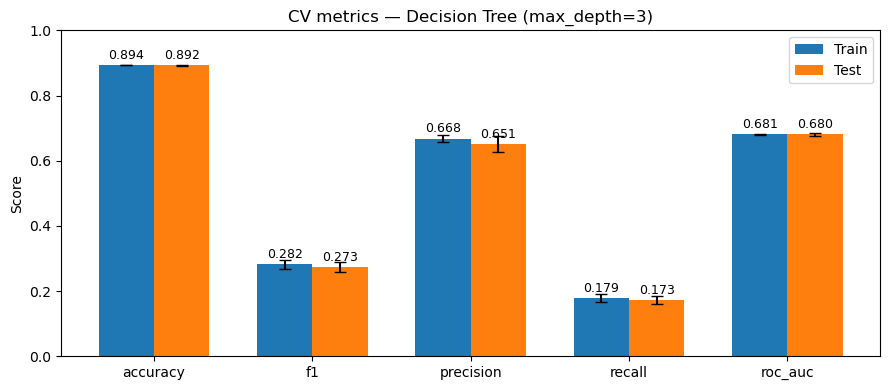

C:\Users\mvana\AppData\Local\Temp\ipykernel_6212\796243269.py:47: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=metrics, showmeans=True)


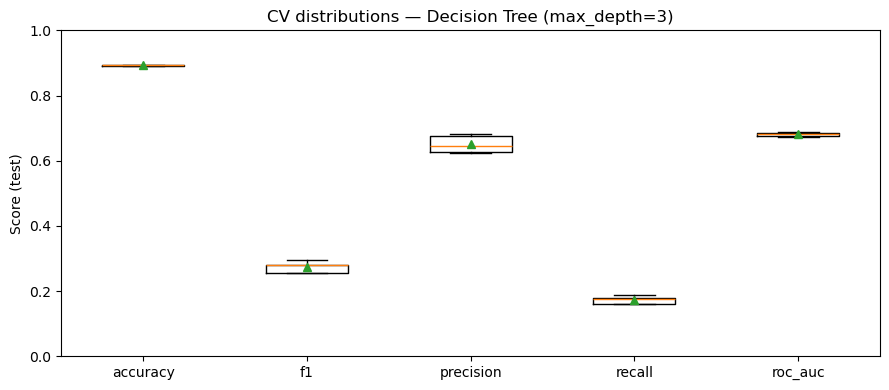

In [24]:
# BONUS: performance plot 
# Create a bar plot showing the mean and the standard deviation for each metric
plot_cv_metrics(scoresCLF, model_name="Decision Tree (max_depth=3)", show_train=True)
boxplot_cv_metrics(scoresCLF, model_name="Decision Tree (max_depth=3)")

Now choose a single metric to perform a grid search on the `max_depth` of the tree.

### Pourquoi choix de ROC AUC pour les précédentes métriques

L’accuracy élevée est trompeuse ici : le jeu est très déséquilibré (peu de “yes”), donc un classifieur qui dit “no” la plupart du temps obtient déjà ~0,89. Mon accuracy n’apporte donc pas une lecture fine de la qualité du modèle.

Au seuil par défaut (0,5), le modèle est conservateur : il prédit “yes” rarement mais, quand il le fait, il a souvent raison (precision ~0,68). L’envers du décor, c’est un recall faible (~0,17) : beaucoup de vrais “yes” ne sont pas détectés (faux négatifs). En résumé, j’ai peu de faux positifs mais encore trop de faux négatifs.

C’est pour cela que j’utilise la ROC-AUC comme métrique principale pour comparer les modèles et tuner les hyperparamètres. La ROC-AUC (≈ 0,68) ne dépend pas d’un seuil particulier et mesure la capacité de ranking du modèle via le couple TPR/Recall vs FPR. Autrement dit, elle me dit qu’il existe des seuils où je peux récupérer plus de positifs (réduire les FN) en acceptant un peu plus de FP — ce que ni l’accuracy ni une unique valeur de précision/rappel ne captent bien.


In [46]:
# Grid search
from sklearn.model_selection import GridSearchCV

param_grid= {
    'Regressor__max_depth': [3, 5, 7, 9, 11, 13,15],
    'Regressor__min_samples_leaf': [1, 5, 10, 20],
}

cv = StratifiedKFold(n_splits=10, shuffle=True)

gridCLF = GridSearchCV(
    estimator=modelCLF,
    param_grid=param_grid,
    scoring='roc_auc',          # choix du roc_auc
    refit=True,
    return_train_score=True,
    cv=cv, n_jobs=-1, verbose=1
)
gridCLF.fit(X, y)

print("Best params:", gridCLF.best_params_)
print("Best ROC AUC:", gridCLF.best_score_)
bestCLF = gridCLF.best_estimator_



Fitting 10 folds for each of 28 candidates, totalling 280 fits
Best params: {'Regressor__max_depth': 11, 'Regressor__min_samples_leaf': 20}
Best ROC AUC: 0.7705522643755837


In [47]:
#### fonction qui permet de regarder les meilleurs paramètres de gridsearch dans un tableau 

def grid_results_table(grid, metric: str | None = None, top: int = 10, round_digits: int = 4):
    """
    Construit un DataFrame compact à partir d'un GridSearchCV *déjà fit*.
    
    Paramètres
    ----------
    grid : GridSearchCV fitted
    metric : str | None
        - Multi-métriques : nom de la métrique (ex: 'f1', 'roc_auc').
        - Mono-métrique   : laisser None (utilise 'score').
    top : int
        Nombre de premières lignes à retourner (affichage).
    round_digits : int
        Arrondi affiché.

    Retour
    ------
    table : DataFrame (complet, trié par rank)
    view  : DataFrame (les top lignes)
    """
    cvdf = pd.DataFrame(grid.cv_results_).copy()
    param_cols = [c for c in cvdf.columns if c.startswith("param_")]

    # Détection des clés selon mono- vs multi-métriques
    # Mono-métrique -> mean_test_score / std_test_score / rank_test_score
    # Multi-métriques -> mean_test_<m> / std_test_<m> / rank_test_<m>
    if "mean_test_score" in cvdf.columns:
        base = "score"
        if metric is not None and f"mean_test_{metric}" in cvdf.columns:
            # Si l'utilisateur donne une métrique existante, on la prend
            base = metric
    else:
        test_metrics = sorted([c.replace("mean_test_", "") for c in cvdf.columns if c.startswith("mean_test_")])
        if not test_metrics:
            raise ValueError("Aucune métrique test trouvée dans cv_results_.")
        base = metric or test_metrics[0]
        if f"mean_test_{base}" not in cvdf.columns:
            raise ValueError(f"Métrique '{base}' introuvable. Dispo: {test_metrics}")

    # Construit les noms de colonnes en tenant compte des deux cas
    def k(prefix, b=base):
        # ex: k('mean_test_') -> 'mean_test_f1'  ou 'mean_test_score'
        if f"{prefix}{b}" in cvdf.columns:
            return f"{prefix}{b}"
        # fallback mono-métrique
        return f"{prefix}score"

    mean_test = k("mean_test_")
    std_test  = k("std_test_")
    rank_test = k("rank_test_")
    mean_train = k("mean_train_")
    std_train  = k("std_train_")

    cols = [rank_test, mean_test, std_test]
    has_train = mean_train in cvdf.columns
    if has_train:
        cols += [mean_train, std_train]

    # Table compacte
    table = cvdf[cols + param_cols].copy()

    # Renommage clair
    MET = (base.upper() if base != "score" else "SCORE")
    rename_map = {
        mean_test:  f"{MET}_Test",
        std_test:   f"{MET}_std_Test",
        rank_test:  "Rank",
    }
    if has_train:
        rename_map[mean_train] = f"{MET}_Train"
        rename_map[std_train]  = f"{MET}_std_Train"

    table.rename(columns=rename_map, inplace=True)

    # Δ |Train - Test|
    if has_train:
        table["DeltaTrainTest"] = (table[f"{MET}_Train"] - table[f"{MET}_Test"]).abs()

    # Tri principal par Rank, puis par Delta si dispo
    sort_cols = ["Rank"]
    if "DeltaTrainTest" in table.columns:
        sort_cols.append("DeltaTrainTest")

    ascending = [True] * len(sort_cols)   # <--- au lieu de [True, True]
    table = table.sort_values(sort_cols, ascending=ascending, na_position='last').reset_index(drop=True)

    # Arrondi
    num_cols = [c for c in table.columns if c not in param_cols and c != "Rank"]
    table[num_cols] = table[num_cols].applymap(lambda x: round(x, round_digits) if pd.notnull(x) and isinstance(x, (int, float, np.floating)) else x)

    # Vue top
    view = table.head(top).copy()
    return table, view

In [48]:
# Après grid.fit(X, y) :
full_table, top10 = grid_results_table(gridCLF, metric='roc_auc', top=10)
print(top10.to_string(index=False))

 Rank  SCORE_Test  SCORE_std_Test  SCORE_Train  SCORE_std_Train  param_Regressor__max_depth  param_Regressor__min_samples_leaf  DeltaTrainTest
    1      0.7706          0.0103       0.8115           0.0035                          11                                 20          0.0410
    2      0.7682          0.0069       0.8352           0.0033                          13                                 20          0.0670
    3      0.7641          0.0128       0.7848           0.0032                           9                                 20          0.0207
    4      0.7624          0.0100       0.8137           0.0030                          11                                 10          0.0513
    5      0.7618          0.0068       0.8564           0.0036                          15                                 20          0.0945
    6      0.7586          0.0128       0.7859           0.0033                           9                                 10          0.0273

C:\Users\mvana\AppData\Local\Temp\ipykernel_6212\3553332738.py:91: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  table[num_cols] = table[num_cols].applymap(lambda x: round(x, round_digits) if pd.notnull(x) and isinstance(x, (int, float, np.floating)) else x)


In [49]:
#### Au vu du tableau, il est plus judicieux de prendre max_depth=9 et min_samples_leaf =20
# ### car il y a moins d'overfitting (detla )

console.print("Au vu du tableau, il est plus judicieux de prendre max_depth=9 et min_samples_leaf =20 \n"
              "car il y a moins d'overfitting (delta le plus faible sur les 10 meilleurs modèles) \n"
              , style="yellow")

bestCLF_max_depth=9
bestCLF_min_samples_leaf=20

Au vu du tableau, il est plus judicieux de prendre max_depth=9 et min_samples_leaf =20 
car il y a moins d'overfitting (delta le plus faible sur les 10 meilleurs modèles) 

Now retrain the model with the selected hyperparameters on your whole train set and evaluate the selected model on the test set :

--- Résultats pour le modèle : Model Decision Tree, Seed = 42
 max_depth=7, min_samples_leaf=20 ---
Métrique   | Train    | Test
---------------------------------------------------------------------------------------------------
Accuracy   |   0.8982 |   0.8926
Precision  |   0.7271 |   0.6445
Recall     |   0.2083 |   0.1830
F1 Score   |   0.3238 |   0.2850
ROC AUC    |   0.7846 |   0.7645
---------------------------------------------------------------------------------------------------


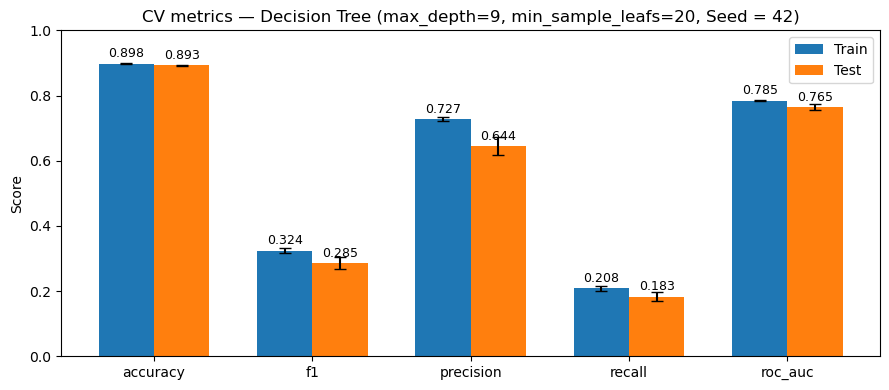

In [51]:
# Test metrics
# create a new train and test dataset with a different seed
modelCLFBest = Pipeline([
    ('preprocessing', preprocessor),
    ('Regressor', DecisionTreeClassifier(max_depth=bestCLF_max_depth,
                                         min_samples_leaf=bestCLF_min_samples_leaf,
                                         random_state=42))
])


modelCLFBest.fit(X_train, y_train)
y_predTestCLFBest = modelCLFBest.predict(X_test)
y_predTrainCLFBest = modelCLFBest.predict(X_train)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoresCLFBest = cross_validate(
    modelCLFBest, X, y,
    scoring= {'accuracy':'accuracy','precision':'precision','recall':'recall','f1':'f1','roc_auc':'roc_auc'},
    cv=cv, n_jobs=-1, return_train_score=True
)


print(scores_table(scoresCLFBest, model_name="Model Decision Tree, Seed = 42\n max_depth=7, min_samples_leaf=20"))
plot_cv_metrics(scoresCLFBest, model_name="Decision Tree (max_depth=9, min_sample_leafs=20, Seed = 42)", show_train=True)



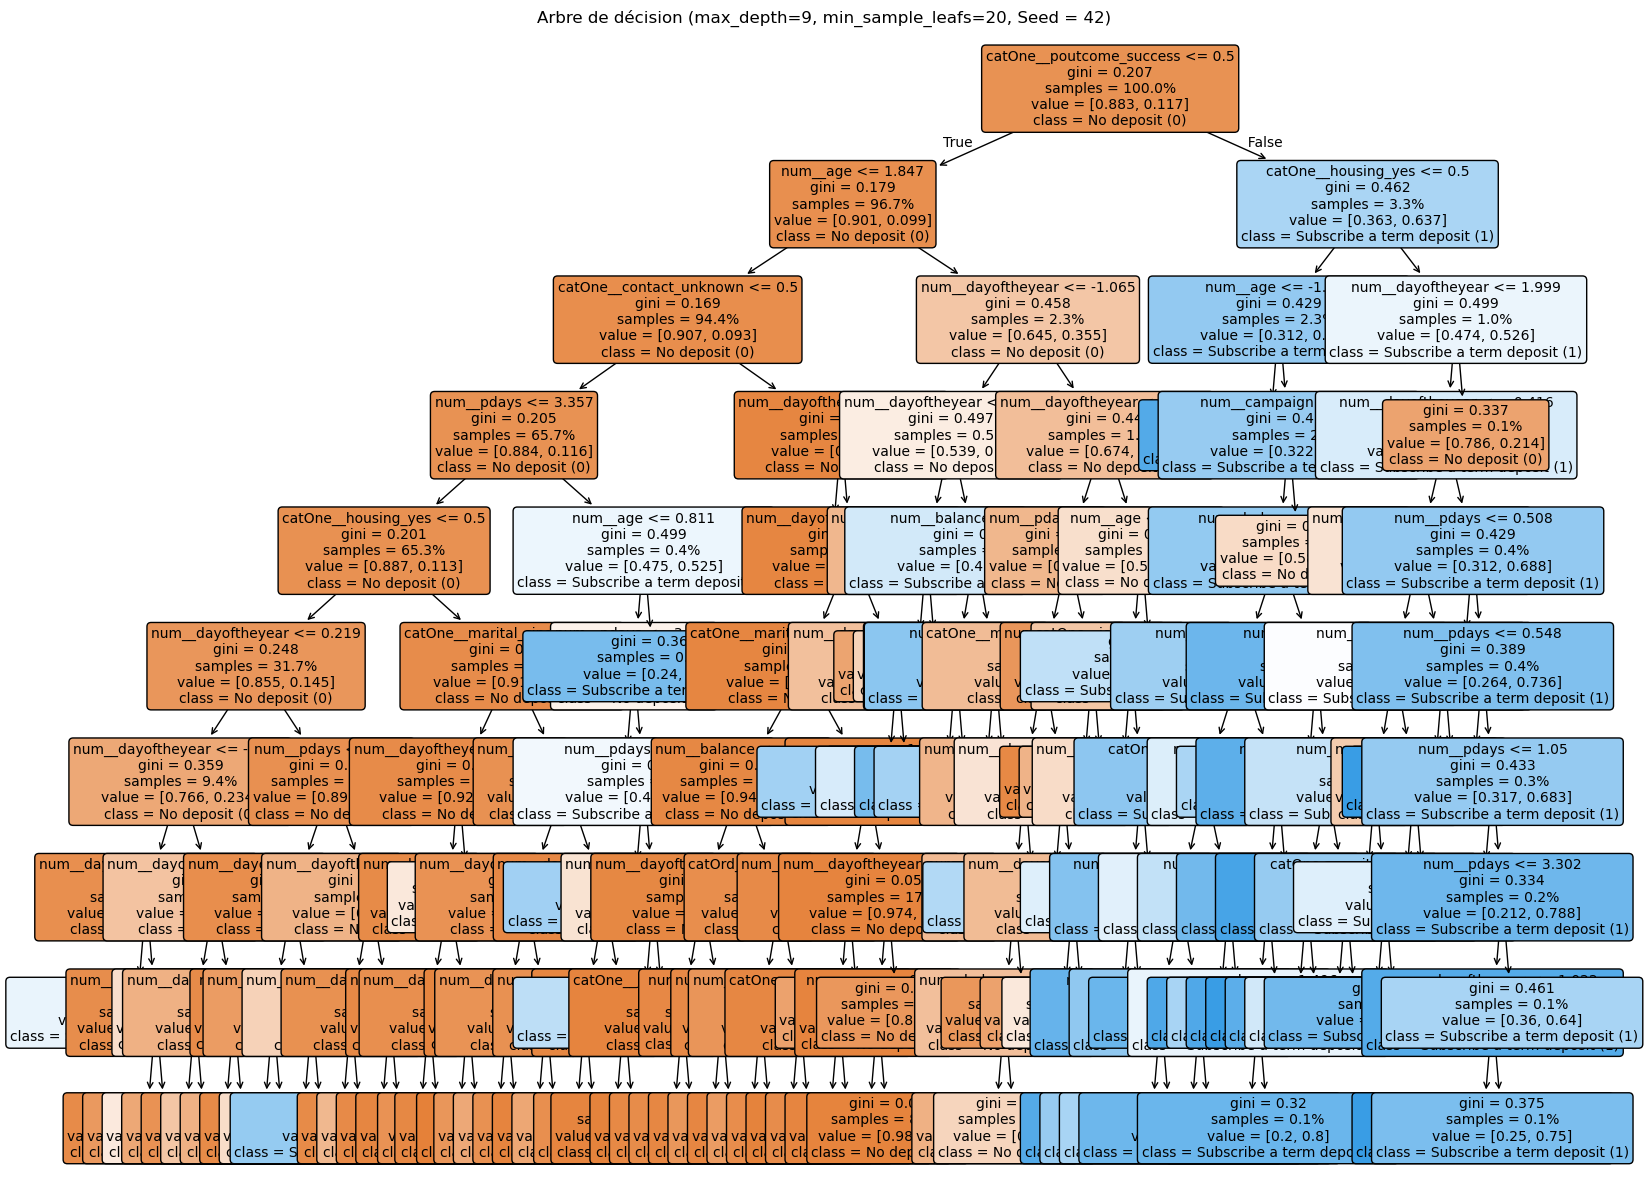

In [53]:
##### visulatisation de l'arbre de décision
# 1) On récupère l'arbre entraîné (dernier step du pipeline)
clf = modelCLFBest.named_steps['Regressor']  # <- c'est un DecisionTreeClassifier

# 2) noms de features après le ColumnTransformer
try:
    feature_names = modelCLFBest.named_steps['preprocessing'].get_feature_names_out()
except AttributeError:
    # Si jamais pas dispo (vieille version sklearn), on met des noms génériques
    n_features = clf.n_features_in_
    feature_names = np.array([f"feat_{i}" for i in range(n_features)])

# 3) Noms de classes alignés avec l'ordre appris par le modèle
class_names = [ "No deposit (0)", "Subscribe a term deposit (1)" ]

# 4) Visualisation de l'arbre
plt.figure(figsize=(18, 15))
plot_tree(
    clf,
    feature_names=feature_names,
    class_names=class_names,
    filled=True,
    rounded=True,
    proportion=True,   # affiche les proportions dans les nœuds
    fontsize=10
)
plt.title("Arbre de décision (max_depth=9, min_sample_leafs=20, Seed = 42)")
plt.show()

What are your observation?  
By looking at the metric results, what is strange? Or at the opposite, obvious?

From theses observations, what are your conclusions?  
In the next sessions, we will look at ensembling to improve performances. But what should you be suspicious? What are the potential risks you identified?  

Propose something, continue to the next section and change your conclusions if you need.

In [58]:
console.print("On remarque que l'Accuracy est trés élevé ~0.89 : train/test quasi identiques\n"
              "→ gap très faible ⇒ peu d’overfitting (bon signe) mais l’accuracy est gonflée par la classe majoritaire\n",
              style="yellow")             
console.print("Le ROC AUC ~0.78  → le modèle discrimine mieux que le hasard \n"
              "On a augmenté un peu le Recall ~0.20 → il est toujours conservateur : quand il dit 'yes' il a souvent raison, mais il rate beaucoup de 'yes'\n"
              " F1 ~0.30 → cohérent avec P élevé / R faible\n", style="yellow")              
console.print("Concernant l'arbre de décision : la structure de l’arbre reste dominée par poutcome_success, puis housing et num_age \n"
              , style="yellow")                  
console.print("Ce qui parait évident : l'accuracy élevée mais peu informative car le jeu de données est déséquilibré", style="yellow")
    

On remarque que l'Accuracy est trés élevé ~0.89 : train/test quasi identiques
→ gap très faible ⇒ peu d’overfitting (bon signe) mais l’accuracy est gonflée par la classe majoritaire

Le ROC AUC ~0.78  → le modèle discrimine mieux que le hasard 
On a augmenté un peu le Recall ~0.20 → il est toujours conservateur : quand il dit 'yes' il a souvent raison, mais 
il rate beaucoup de 'yes'
 F1 ~0.30 → cohérent avec P élevé / R faible

Concernant l'arbre de décision : la structure de l’arbre reste dominée par poutcome_success, puis housing et 
num_age 

Ce qui parait évident : l'accuracy élevée mais peu informative car le jeu de données est déséquilibré

### Introducing Ensemble Learning with Bagging models.

Let's train multiple classifiers in parallel in a bootstraping approach! 

Bagging stands for ***Boostrap AGGregatING***.

The following [post](https://blog.octo.com/les-methodes-ensemblistes-pour-algorithmes-de-machine-learning/) will give you an overview of these methods and their advantages and drawbacks

**The train test split using a seed equals to 42 will be used in the following part**

In [55]:
# train_test split (you can copy paste the previously declared cell)
# X_train, X_test, y_train, y_test = None
## c'est ce qui a été fait plus haut
# modelCLFBest = Pipeline([
#     ('preprocessing', preprocessor),
#     ('Regressor', DecisionTreeClassifier(max_depth=bestCLF_max_depth,
#                                          min_samples_leaf=bestCLF_min_samples_leaf,
#                                          random_state=42))
# ])


# modelCLFBest.fit(X_train, y_train)
# y_predTestCLFBest = modelCLFBest.predict(X_test)
# y_predTrainCLFBest = modelCLFBest.predict(X_train)


#### Using Random Forest

The concept of random forest is explained in this [post](https://medium.com/analytics-vidhya/understanding-the-random-forest-algorithm-79b87bdde79a).

Now the best parameters of the previous classifier will be used in a using a bagging classifier
[sklearn : Random Forest Doc](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html?highlight=random%20forest#sklearn.ensemble.RandomForestClassifier)

We will use grid search on the `n_estimators` and `max_depth` parameters. 

In [ ]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier


modelRFC = Pipeline([
    ('preprocessing', preprocessor),
    ('Regressor', RandomForestClassifier(random_state=42))
])


modelRFC.fit(X_train, y_train)


param_grid= {
     'Regressor__n_estimators': [20, 50, 100, 200 ,300, 400,500,600],
     'Regressor__max_depth': [3,5,7,9,11,15,17,21]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

gridRFC = GridSearchCV(
    estimator=modelRFC,
    param_grid=param_grid,
    scoring='roc_auc',          # <- une seule métrique
    refit=True,
    return_train_score=True,
    cv=cv, n_jobs=-1, verbose=1
)
gridRFC.fit(X, y)



Fitting 5 folds for each of 64 candidates, totalling 320 fits


KeyboardInterrupt: 

In [ ]:
print("Best params:", gridRFC.best_params_)
print("Best F1 (CV):", gridRFC.best_score_)
bestRFC = gridRFC.best_estimator_

full_table, top10 = grid_results_table(gridRFC, metric='roc_auc', top=10)
print(top10.to_string(index=False))

Best params: {'Regressor__max_depth': 15, 'Regressor__n_estimators': 400}
Best F1 (CV): 0.7911409633180659
 Rank  SCORE_Test  SCORE_std_Test  SCORE_Train  SCORE_std_Train  param_Regressor__max_depth  param_Regressor__n_estimators  DeltaTrainTest
    1      0.7911          0.0101       0.9535           0.0007                          15                            400          0.1624
    2      0.7911          0.0105       0.9538           0.0008                          15                            600          0.1627
    3      0.7911          0.0091       0.9533           0.0007                          15                            200          0.1622
    4      0.7910          0.0096       0.9534           0.0010                          15                            300          0.1624
    5      0.7909          0.0103       0.9537           0.0007                          15                            500          0.1627
    6      0.7893          0.0109       0.9787           0.

C:\Users\mvana\AppData\Local\Temp\ipykernel_6212\3553332738.py:91: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  table[num_cols] = table[num_cols].applymap(lambda x: round(x, round_digits) if pd.notnull(x) and isinstance(x, (int, float, np.floating)) else x)


How much estimators should we use for obtaining an optimal result? (in terms of time and performance)

In [ ]:
def pick_n_estimators_by_one_se(grid, metric='f1', prefer_faster=True):
    cv = pd.DataFrame(grid.cv_results_).copy()
    # colonnes: mean_test_<metric>, std_test_<metric>, mean_fit_time
    mcol, scol = f"mean_test_{metric}", f"std_test_{metric}"
    if mcol not in cv:  # mono-métrique -> 'mean_test_score'
        mcol, scol = "mean_test_score", "std_test_score"

    # Regrouper par n_estimators (adapter le nom du param selon le pipe)
    ncol = 'param_Regressor__n_estimators'  # RF simple
    if ncol not in cv:
        ncol = 'param_Regressor__estimator__n_estimators'  # si Bagging(RandomForest)

    agg = (cv.groupby(ncol)
             .agg(mean_score=(mcol,'mean'),
                  std_score=(scol,'mean'),
                  mean_fit_time=('mean_fit_time','mean'))
             .reset_index())
    # meilleur score et seuil 1-SE
    best_idx = agg['mean_score'].idxmax()
    best = agg.loc[best_idx, 'mean_score']
    se = agg.loc[best_idx, 'std_score']

    # candidats dans (best - SE, +∞)
    cand = agg[agg['mean_score'] >= best - se].copy()

    # choisir le plus petit n_estimators (ou le plus rapide)
    if prefer_faster:
        cand = cand.sort_values(['mean_fit_time', ncol], ascending=[True, True])
    else:
        cand = cand.sort_values(ncol, ascending=True)

    chosen = cand.iloc[0]
    return int(chosen[ncol]), agg.sort_values(ncol)

# Exemple d’utilisation (après grid.fit)
n_star, curve = pick_n_estimators_by_one_se(gridRFC, metric='roc_auc', prefer_faster=True)
print("n_estimators choisi (one-SE) :", n_star)
display(curve)  # pour montrer perf & temps vs n

n_estimators choisi (one-SE) : 20


,param_Regressor__n_estimators,mean_score,std_score,mean_fit_time
0,20,0.768185,0.011457,3.596455
1,50,0.775494,0.011319,7.258042
2,100,0.776592,0.011206,13.493903
3,200,0.778416,0.011390,22.369533
4,300,0.778655,0.011469,30.500536
5,400,0.778937,0.011651,42.090892
6,500,0.778920,0.011595,54.193950
7,600,0.778918,0.011629,63.320796


In [ ]:
console.print("Du point du temps, les plus petits estimators mettent moins de temps que les plus grands, ce qui est logique \n"
              "Toutefoi, en observant le tableau des meilleurs hyperparamètres avec le delta entre train et split, est judicieux \n"
              "de prendre n_estimators = 300 (qui est dans la moyenne en terme de temps), ainsi que max_depth = 11 \n"
              "qui est le 7ème meilleur modèle du point de vue ROC AUC (trés performant) et qui overfit le moins",style="yellow")

Du point du temps, les plus petits estimators mettent moins de temps que les plus grands, ce qui est logique 
Toutefoi, en observant le tableau des meilleurs hyperparamètres avec le delta entre train et split, est judicieux 
de prendre n_estimators = 300 (qui est dans la moyenne en terme de temps), ainsi que max_depth = 11 
qui est le 7ème meilleur modèle du point de vue ROC AUC (trés performant) et qui overfit le moins

Now retrain the model with the selected hyperparameters on your whole train set and evaluate the selected model on the test set :

--- Résultats pour le modèle : Model Random Forest, Seed = 42
 max_depth=11, n_estimators=300 ---
Métrique   | Train    | Test
-------------------------------------------------------------------------------------------------
Accuracy   |   0.8893 |   0.8887
Precision  |   0.7087 |   0.6952
Recall     |   0.0912 |   0.0851
F1 Score   |   0.1610 |   0.1511
ROC AUC    |   0.7756 |   0.7682
-------------------------------------------------------------------------------------------------


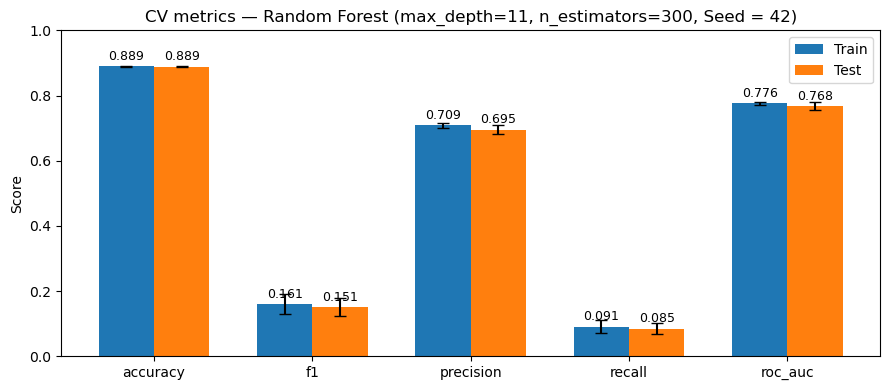

In [59]:
# Test metrics
bestRCF_max_depth = 11
bestRCF_n_estimators=300

modelRCFBest = Pipeline([
    ('preprocessing', preprocessor),
    ('Regressor', RandomForestClassifier(max_depth=bestRCF_max_depth,
                                         min_samples_leaf=bestRCF_n_estimators,
                                         random_state=42))
])


modelRCFBest.fit(X_train, y_train)
y_predTestRCFBest = modelRCFBest.predict(X_test)
y_predTrainRCFBest = modelRCFBest.predict(X_train)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoresRCFBest = cross_validate(
    modelRCFBest, X, y,
    scoring= {'accuracy':'accuracy','precision':'precision','recall':'recall','f1':'f1','roc_auc':'roc_auc'},
    cv=cv, n_jobs=-1, return_train_score=True
)


print(scores_table(scoresRCFBest, model_name="Model Random Forest, Seed = 42\n max_depth=11, n_estimators=300"))
plot_cv_metrics(scoresRCFBest, model_name="Random Forest (max_depth=11, n_estimators=300, Seed = 42)", show_train=True)

#### Other Random Forest effect

The random forest model can attribute an importance value to features, [explanations here](https://towardsdatascience.com/explaining-feature-importance-by-example-of-a-random-forest-d9166011959e)

Let's train another random forest and display an histogramm with it :

In [60]:
# display features' importance => use the RandomForest Object
from sklearn.ensemble import BaggingClassifier

def rf_feature_importances_df(pipe, top=20, group_original=False, normalize=True):
    """
    pipe : Pipeline(fitted) avec steps ['preprocessing'] et ['Regressor'] (RandomForest
           ou BaggingClassifier(estimator=RandomForest))
    Retourne (top_df, full_df) triés décroissants par importance.
    - group_original=True : agrège les one-hot par variable d'origine (ex: housing_yes/no -> housing)
    """
    # 1) noms de features après le préprocessing
    feat_names = pipe.named_steps['preprocessing'].get_feature_names_out()

    # 2) importances côté modèle
    clf = pipe.named_steps['Regressor']
    if hasattr(clf, "feature_importances_"):                # RandomForestClassifier
        imps = clf.feature_importances_
    elif isinstance(clf, BaggingClassifier):                # Bagging(RandomForest)
        imps = np.mean([est.feature_importances_ for est in clf.estimators_], axis=0)
    else:
        raise ValueError("Le dernier step n'expose pas feature_importances_ (pas un RF).")

    df = pd.DataFrame({"feature": feat_names, "importance": imps})

    # normalisation (facilite la lecture)
    if normalize and df["importance"].sum() > 0:
        df["importance"] = df["importance"] / df["importance"].sum()

    df = df.sort_values("importance", ascending=False).reset_index(drop=True)

    if group_original:
        # enlève le préfixe du transformer ('num__', 'catOne__', ...)
        base = df["feature"].str.split("__", n=1).str[-1]
        # regroupe les catégories one-hot par variable (avant le premier '_')
        df["orig"] = base.str.split("_", n=1).str[0]
        g = (df.groupby("orig", as_index=False)["importance"].sum()
               .sort_values("importance", ascending=False)
               .reset_index(drop=True))
        return g.head(top), g

    return df.head(top), df

import matplotlib.pyplot as plt

def plot_feature_importances(df_full, title="RandomForest — Top features", top=20):
    data = df_full.head(top).iloc[::-1]  # du bas vers le haut
    plt.figure(figsize=(8, max(3, 0.35*top)), dpi=130)
    plt.barh(data.iloc[:,0], data["importance"])
    plt.xlabel("Importance (normalisée)")
    plt.title(title)
    plt.tight_layout()
    plt.show()

         feature  importance       std
0        contact    0.041159  0.003684
1        housing    0.026628  0.003654
2       poutcome    0.023578  0.001759
3   dayoftheyear    0.022309  0.001184
4            age    0.009201  0.000894
5        balance    0.006826  0.001502
6          pdays    0.004937  0.000919
7        marital    0.004678  0.000764
8       previous    0.004005  0.001291
9       campaign    0.003959  0.000400
10          loan    0.002536  0.000514
11     education    0.001013  0.000351
12           job    0.000990  0.000594
13       default   -0.000017  0.000004


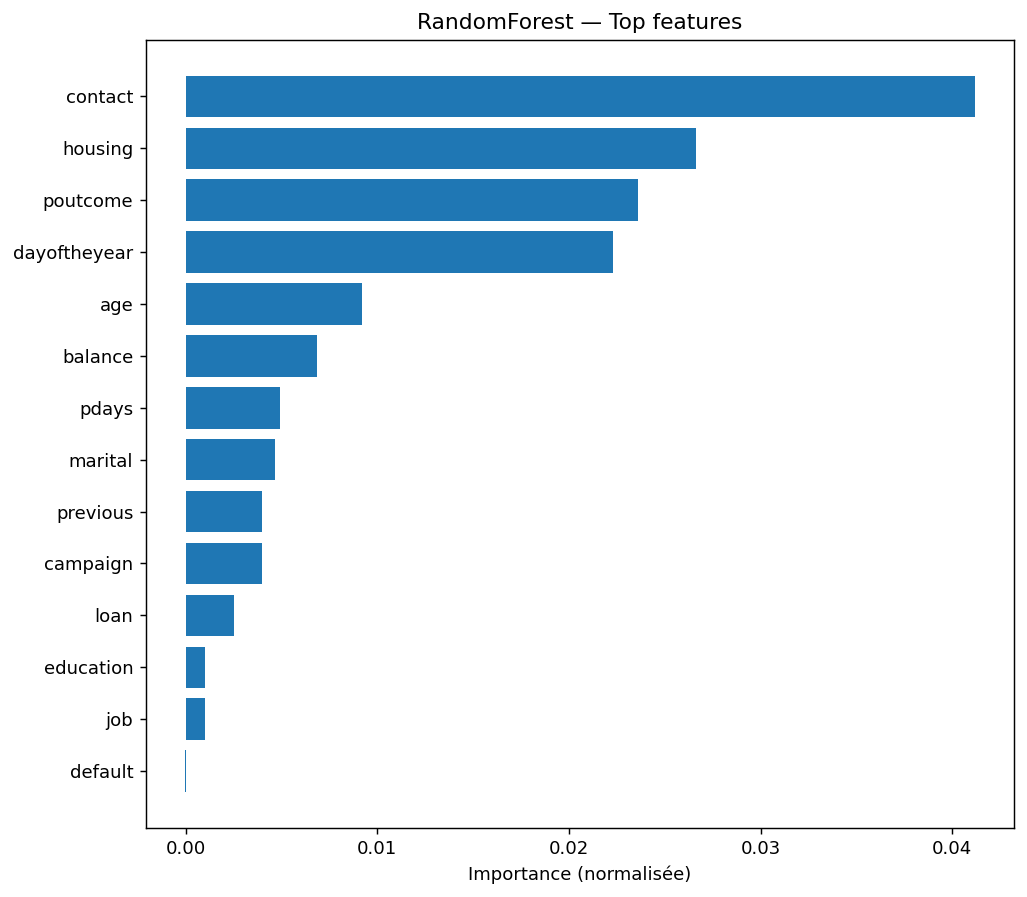

In [61]:
from sklearn.inspection import permutation_importance

r = permutation_importance(
    modelRCFBest,           # le Pipeline
    X_test, y_test,
    n_repeats=10,
    scoring='roc_auc',
    random_state=42,
    n_jobs=-1
)


feat_names = X_train.columns if hasattr(X_train, "columns") else [f"feat_{i}" for i in range(X_train.shape[1])]
pi = (pd.DataFrame({
        "feature": feat_names,
        "importance": r.importances_mean,
        "std": r.importances_std
     })
     .sort_values("importance", ascending=False)
     .reset_index(drop=True))
print(pi.head(20))


plot_feature_importances(pi,title="RandomForest — Top features", top=20)

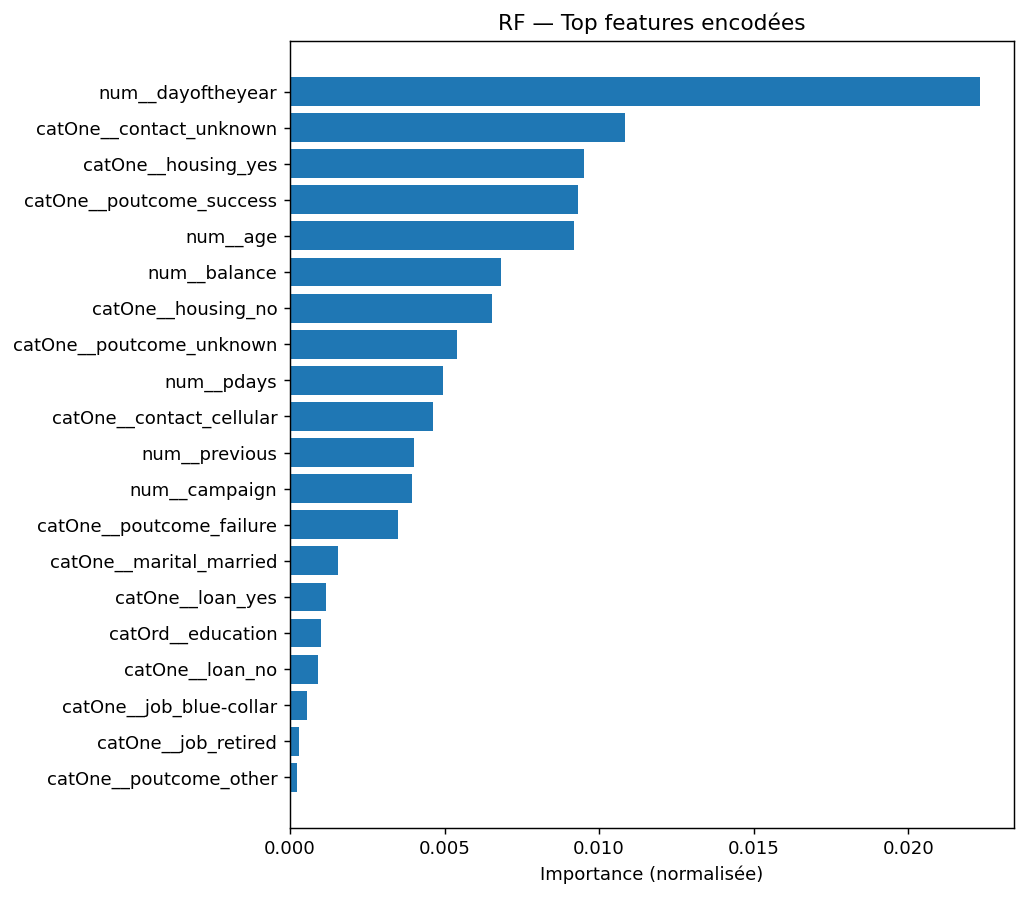

                     feature  importance       std
0          num__dayoftheyear    0.022309  0.001184
1    catOne__contact_unknown    0.010824  0.002480
2        catOne__housing_yes    0.009511  0.002094
3   catOne__poutcome_success    0.009302  0.001369
4                   num__age    0.009201  0.000894
5               num__balance    0.006826  0.001502
6         catOne__housing_no    0.006538  0.001761
7   catOne__poutcome_unknown    0.005405  0.001198
8                 num__pdays    0.004937  0.000919
9   catOne__contact_cellular    0.004630  0.001691
10             num__previous    0.004005  0.001291
11             num__campaign    0.003959  0.000400
12  catOne__poutcome_failure    0.003494  0.000250
13   catOne__marital_married    0.001547  0.000529
14          catOne__loan_yes    0.001163  0.000273
15         catOrd__education    0.001013  0.000351
16           catOne__loan_no    0.000906  0.000251
17   catOne__job_blue-collar    0.000556  0.000339
18       catOne__job_retired   

In [64]:
prep = modelRCFBest.named_steps['preprocessing']
clf  = modelRCFBest.named_steps['Regressor']

Xtr_valid = prep.transform(X_test)
if hasattr(Xtr_valid, "toarray"):  # si sparse
    Xtr_valid = Xtr_valid.toarray()

r_enc = permutation_importance(
    clf, Xtr_valid, y_test,
    n_repeats=10, scoring='roc_auc', random_state=42, n_jobs=-1
)
feat_enc = prep.get_feature_names_out()
pi_enc = (pd.DataFrame({"feature": feat_enc,
                        "importance": r_enc.importances_mean,
                        "std": r_enc.importances_std})
          .sort_values("importance", ascending=False)
          .reset_index(drop=True))
plot_feature_importances(pi_enc, title="RF — Top features encodées", top=20)



print(pi_enc.head(20))

What is the most important feature?

Sur le graphe 1, la variable la plus importante est 'contact', suivi de 'housing'.
J'ai normalisé les scores, pour mieux comparer les varibles entre eux.
Tutefois, sur le graphe 2, on voit que si on prend les modalités et non pas que les varaiables, c'est la catégorie numérique dayoftheyear qui est la variable la plus importante suivi de la modélité CatOne_contact_unknown". 

A lot of features have low importance and probably add noise which reduce the performance of the classifier, do a feature selection by recursive elemination to automatically select the subset of features that gives you the best model predictions.

You can have a look at : 

https://scikit-learn.org/stable/modules/feature_selection.html

https://scikit-learn.org/stable/auto_examples/feature_selection/plot_rfe_with_cross_validation.html#sphx-glr-auto-examples-feature-selection-plot-rfe-with-cross-validation-py

In [65]:
# Feature selection with recursive elimination
# Do another grid search on your model with the subset of selected features

from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone


r = permutation_importance(
    modelRCFBest,           # le Pipeline
    X_test, y_test,         # <- y_true !
    n_repeats=10,
    scoring='roc_auc',
    random_state=42,
    n_jobs=-1
)

# Hyperparamètres "best"
best_max_depth = bestRCF_max_depth
best_min_samples_leaf = 20            
best_n_estimators = 300              

# Hyperparamètres centralisés
rf_params = dict(
    n_estimators=300,
    max_depth=bestRCF_max_depth,
    min_samples_leaf=20,         
    class_weight='balanced',
    n_jobs=-1,
    random_state=42
)
rf_best = RandomForestClassifier(**rf_params) 

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Sélecteur RFE sur les FEATURES TRANSFORMÉES
selector = RFECV(
    estimator=clone(rf_best),
    step=1,
    cv=cv,
    scoring="roc_auc",
    min_features_to_select=1,
    n_jobs=-1
)

# Pipeline complet: preprocessing -> RFECV -> RandomForest final
pipe_rfe_rf = Pipeline([
    ('preprocessing', preprocessor),
    ('feature_selection', selector),
    ('Regressor', rf_best)
])

# Fit final pour récupérer les features retenues
pipe_rfe_rf.fit(X_train, y_train)

# Fit + évaluation CV
scores = cross_validate(
    pipe_rfe_rf, X, y,
    scoring={'accuracy':'accuracy','precision':'precision','recall':'recall','f1':'f1','roc_auc':'roc_auc'},
    cv=cv, n_jobs=-1, return_train_score=True
)
print("F1 (CV):", scores['test_f1'].mean(), "AUC (CV):", scores['test_roc_auc'].mean())

# Nombre de features retenues côté transformé
n_sel = pipe_rfe_rf.named_steps['feature_selection'].n_features_
print(f"Nombre de colonnes sélectionnées (après preprocess): {n_sel}")

# Récupérer les noms après preprocessing
feat_names = pipe_rfe_rf.named_steps['preprocessing'].get_feature_names_out()
support = pipe_rfe_rf.named_steps['feature_selection'].support_
ranking = pipe_rfe_rf.named_steps['feature_selection'].ranking_

selected_features = pd.DataFrame({
    'feature': feat_names,
    'selected': support,
    'ranking': ranking
}).sort_values(['selected','ranking'], ascending=[False, True])

print("Nombre de features retenues :", support.sum())
print(selected_features[selected_features['selected']].head(20).to_string(index=False))





F1 (CV): 0.45543616452588387 AUC (CV): 0.7923607667940777
Nombre de colonnes sélectionnées (après preprocess): 9
Nombre de features retenues : 9
                 feature  selected  ranking
                num__age      True        1
            num__balance      True        1
           num__campaign      True        1
              num__pdays      True        1
       num__dayoftheyear      True        1
     catOne__housing_yes      True        1
catOne__contact_cellular      True        1
 catOne__contact_unknown      True        1
catOne__poutcome_success      True        1


rappel : on fait une sélection automatique de variables (feature selection) à l’intérieur d’un pipeline puis on ré-entraîne/évalue un RandomForest avec seulement les variables gardées.

On part d’un RandomForest “best” (avec hyperparamètres : n_estimators=300, max_depth=bestRCF_max_depth, min_samples_leaf=20, class_weight='balanced'…), et on définit une validation croisée stratifiée 5-fold (StratifiedKFold) pour garder la même proportion de classes dans chaque fold.

le RFECV : Recursive Feature Elimination with Cross-Validation, après le préprocessing (preprocessor : scaling/one-hot encodage, etc.), essaye des sous-ensembles de features en retirant 1 feature à la fois (step=1) et il choisit le nombre de features qui maximise roc_auc en CV.

Ensuite, le pipeline complet preprocessing -> RFECV -> RandomForest final est entraîné, puis on fait un cross_validate pour obtenir des métriques moyennes en CV.

Les sorties en résumé :

F1 (CV) ≈ 0.455 et AUC (CV) ≈ 0.792 : le  modèle discrimine plutôt bien (AUC correcte), mais le compromis précision/rappel à un seuil “standard” reste moyen (F1 plus faible).

RFECV a retenu 9 colonnes (dans l’espace après preprocessing), et on liste exactement lesquelles : num__age, num__balance, num__campaign, num__pdays, num__dayoftheyear + 4 variables one-hot (housing_yes, contact_cellular, contact_unknown, poutcome_success). Toutes ont ranking=1, ce sont celles conservées, les autres ont été éliminées par RFECV.

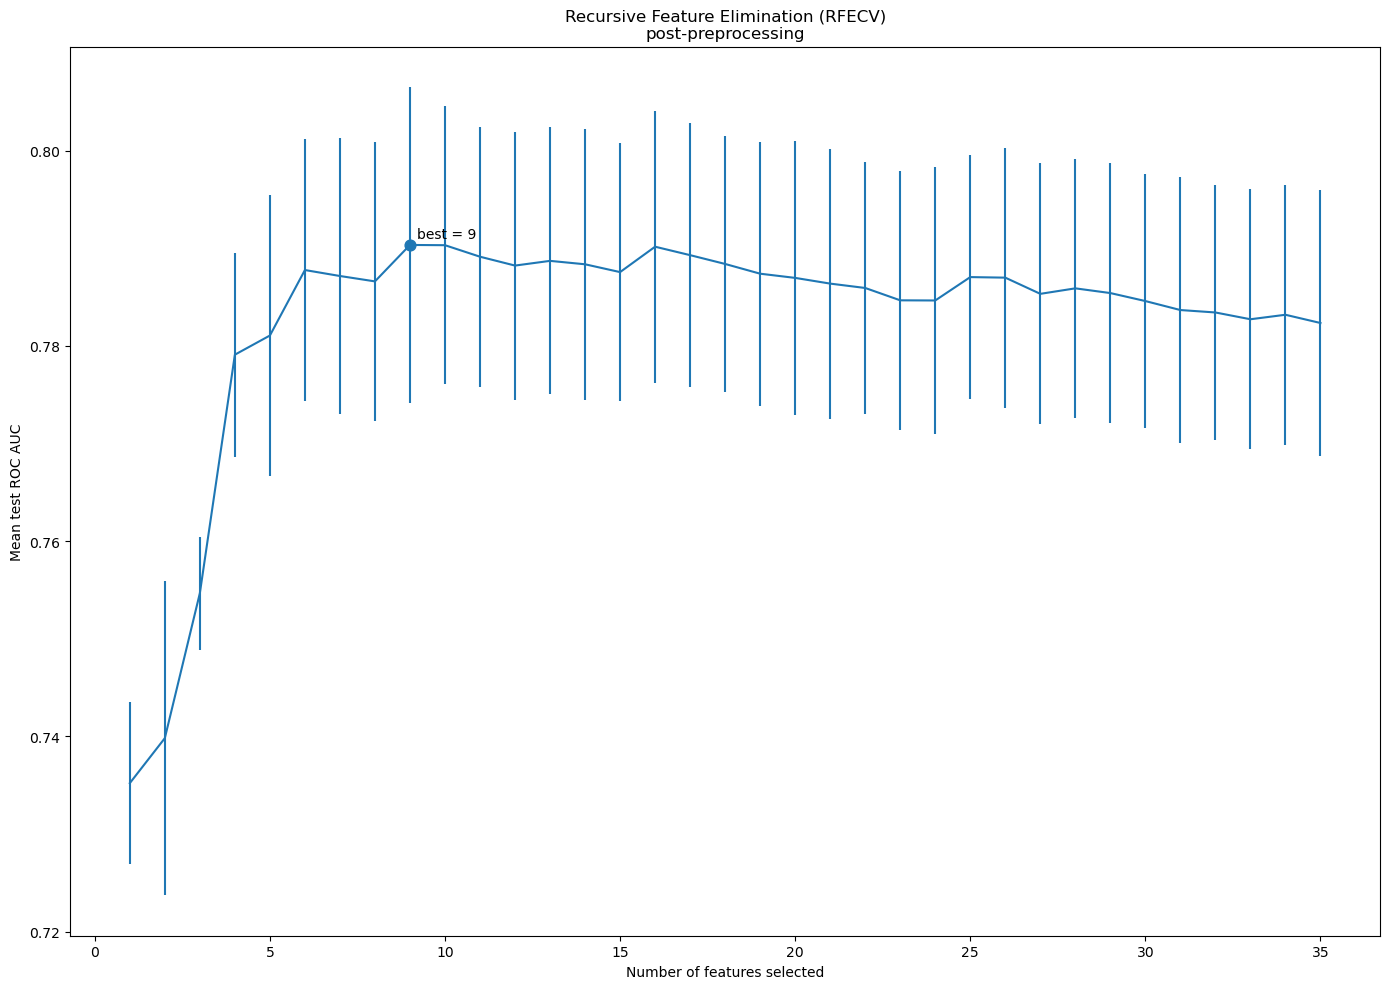

In [66]:
# Récupérer l'objet RFECV entraîné depuis le pipeline
rfecv = pipe_rfe_rf.named_steps['feature_selection']

# --- Préparer les résultats ---
if hasattr(rfecv, "cv_results_") and rfecv.cv_results_ is not None:
    # scikit-learn récents : cv_results_ contient n_features / mean_test_score / std_test_score
    keys = ["n_features", "mean_test_score", "std_test_score"]
    data = {k: rfecv.cv_results_[k] for k in keys if k in rfecv.cv_results_}
    cv_results = pd.DataFrame(data)
else:
    # Compatibilité anciennes versions: grid_scores_ seulement
    # -> pas d'écart-type disponible; on met 0
    scores = np.array(rfecv.grid_scores_)
    n = np.arange(1, len(scores) + 1)
    cv_results = pd.DataFrame({
        "n_features": n,
        "mean_test_score": scores,
        "std_test_score": np.zeros_like(scores, dtype=float)
    })

# Ordonner par nombre de variables (au cas où)
cv_results = cv_results.sort_values("n_features", kind="mergesort").reset_index(drop=True)

# --- Plot ---
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test ROC AUC")  # on évalue en roc_auc dans ton setup
plt.errorbar(
    x=cv_results["n_features"],
    y=cv_results["mean_test_score"],
    yerr=cv_results["std_test_score"],
)
plt.title("Recursive Feature Elimination (RFECV)\npost-preprocessing")
plt.tight_layout()


### point pour mailleur variable
best_idx = cv_results["mean_test_score"].idxmax()
best_x = cv_results.loc[best_idx, "n_features"]
best_y = cv_results.loc[best_idx, "mean_test_score"]
plt.scatter([best_x], [best_y], s=60, zorder=3)
plt.annotate(f"best = {best_x}", (best_x, best_y), xytext=(5,5), textcoords="offset points")
# plt.xticks(cv_results["n_features"]) ### tous les points sur l'axe des x

plt.show()

On voit bien que le meilleur choix est à 9 varaibles, mais 17 est aussi trés proches.

We removed the duration feature in our dataset

Read this feature description on the dataset description ([here on data.world](https://data.world/uci/bank-marketing) or [here on kaggle](https://www.kaggle.com/janiobachmann/bank-marketing-dataset)).

How would the previously trained models perform with this feature?

In [ ]:
print(dfall['duration'])
df_duration = df.copy()
df_duration['duration']=dfall['duration'] ### on reattribut à df_duration la variable duration de dfall
df_duration.info()


0         261
1         151
2          76
3          92
4         198
         ... 
45206     977
45207     456
45208    1127
45209     508
45210     361
Name: duration, Length: 45211, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   age           45211 non-null  int64 
 1   job           45211 non-null  object
 2   marital       45211 non-null  object
 3   education     45211 non-null  object
 4   default       45211 non-null  object
 5   balance       45211 non-null  int64 
 6   housing       45211 non-null  object
 7   loan          45211 non-null  object
 8   contact       45211 non-null  object
 9   campaign      45211 non-null  int64 
 10  pdays         45211 non-null  int64 
 11  previous      45211 non-null  int64 
 12  poutcome      45211 non-null  object
 13  y             45211 non-null  object
 14  dayoftheyear  45

In [68]:

# Colonnes à traiter
num_cols2 = ['age', 'balance', 'campaign', 'pdays','previous','dayoftheyear','duration']
# Fusion dans un seul transformateur
preprocessor2 = ColumnTransformer([
    ('num', num_pipeline, num_cols2),
    ('catOrd', cat_pipelineOrd, cat_ordinal),
    ('catOne', cat_pipelineOne, cat_nominal),   
], remainder='drop') 

X2 = df_duration.drop(columns=['y'])




X_traind, X_testd, y_traind, y_testd = train_test_split(X2, y, random_state = 41, 
                                                    test_size = 0.3, 
                                                    stratify = y)


# Pipeline complet: preprocessing -> RFECV -> RandomForest final
pipe_rfe_rf2 = Pipeline([
    ('preprocessing', preprocessor2),
    ('feature_selection', selector),
    ('Regressor', rf_best)
])

# Fit final pour récupérer les features retenues
pipe_rfe_rf2.fit(X_traind, y_traind)


check_target_balance(y_traind)  # y en {0,1}

# Fit + évaluation CV
scores_duration= cross_validate(
    pipe_rfe_rf2, X2, y,
    scoring={'accuracy':'accuracy','precision':'precision','recall':'recall','f1':'f1','roc_auc':'roc_auc'},
    cv=cv, n_jobs=-1, return_train_score=True
)
print("F1 (CV):", scores_duration['test_f1'].mean(), "AUC (CV):", scores_duration['test_roc_auc'].mean())

# Fit final pour récupérer les features retenues
pipe_rfe_rf2.fit(X_traind, y_traind)

# Récupérer les noms après preprocessing
feat_names2 = pipe_rfe_rf2.named_steps['preprocessing'].get_feature_names_out()
support2 = pipe_rfe_rf2.named_steps['feature_selection'].support_
ranking2 = pipe_rfe_rf2.named_steps['feature_selection'].ranking_

selected_features2 = pd.DataFrame({
    'feature': feat_names2,
    'selected': support2,
    'ranking': ranking2
}).sort_values(['selected','ranking'], ascending=[False, True])



Comptes par classe:
 y
0    27945
1     3702

Proportions par classe:
 y
0    0.883
1    0.117

Minority rate: 0.117 | Majority rate: 0.883 | IR: 7.5
Conclusion: Target FORTEMENT déséquilibrée.
F1 (CV): 0.5685897536655532 AUC (CV): 0.9268494662277751


In [69]:
print("Nombre de features retenues avec 'duration', :", support2.sum())
print(selected_features2[selected_features2['selected']].head(20).to_string(index=False))

Nombre de features retenues avec 'duration', : 7
                 feature  selected  ranking
                num__age      True        1
              num__pdays      True        1
       num__dayoftheyear      True        1
           num__duration      True        1
     catOne__housing_yes      True        1
 catOne__contact_unknown      True        1
catOne__poutcome_success      True        1


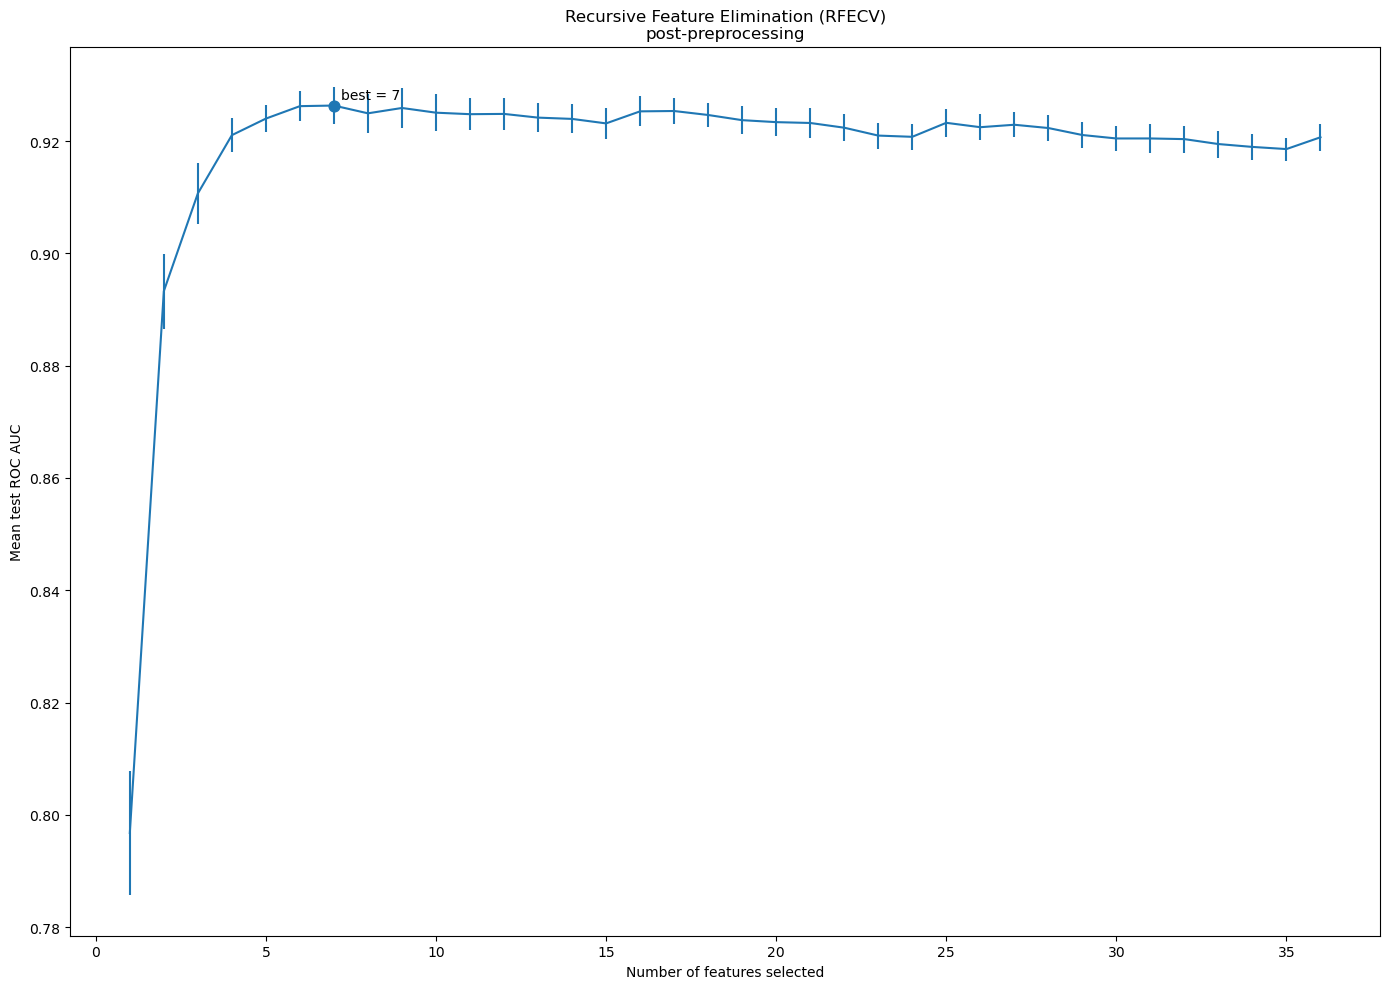

In [70]:
# Récupérer l'objet RFECV entraîné depuis le pipeline
rfecv2 = pipe_rfe_rf2.named_steps['feature_selection']

# --- Préparer les résultats ---
if hasattr(rfecv2, "cv_results_") and rfecv2.cv_results_ is not None:
    # scikit-learn récents : cv_results_ contient n_features / mean_test_score / std_test_score
    keys = ["n_features", "mean_test_score", "std_test_score"]
    data = {k: rfecv2.cv_results_[k] for k in keys if k in rfecv.cv_results_}
    cv_results2 = pd.DataFrame(data)
else:
    # Compatibilité anciennes versions: grid_scores_ seulement
    # -> pas d'écart-type disponible; on met 0
    scores = np.array(rfecv.grid_scores_)
    n = np.arange(1, len(scores) + 1)
    cv_results2 = pd.DataFrame({
        "n_features": n,
        "mean_test_score": scores,
        "std_test_score": np.zeros_like(scores, dtype=float)
    })

# Ordonner par nombre de variables (au cas où)
cv_results2 = cv_results2.sort_values("n_features", kind="mergesort").reset_index(drop=True)

# --- Plot ---
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test ROC AUC")  # on évalue en roc_auc dans ton setup
plt.errorbar(
    x=cv_results2["n_features"],
    y=cv_results2["mean_test_score"],
    yerr=cv_results2["std_test_score"],
)
plt.title("Recursive Feature Elimination (RFECV)\npost-preprocessing")
plt.tight_layout()


### point pour mailleur variable
best_idx = cv_results2["mean_test_score"].idxmax()
best_x = cv_results2.loc[best_idx, "n_features"]
best_y = cv_results2.loc[best_idx, "mean_test_score"]
plt.scatter([best_x], [best_y], s=60, zorder=3)
plt.annotate(f"best = {best_x}", (best_x, best_y), xytext=(5,5), textcoords="offset points")
# plt.xticks(cv_results2["n_features"]) ### tous les points sur l'axe des x

plt.show()

### Pourquoi différence avec ou sans duration ? => data leakage 

La grosse différence vient d’un seul point : la duration est la durée d’appel, et c’est une variable très “proche” de la cible y, que l'on cherche à prédire .

Pourquoi les scores explosent avec duration ?
Avant (sans duration) : AUC ≈ 0.79, F1 ≈ 0.46       
Le modèle doit se débrouiller avec des signaux “indirects” (poutcome, contact, housing, âge, etc.).

Après (avec duration) : AUC ≈ 0.93, F1 ≈ 0.57           
duration est quasi un proxy de la décision finale : un appel long arrive beaucoup plus souvent quand il y a un “yes”.
Du coup, le modèle sépare beaucoup mieux les classes, et RFECV sélectionne num__duration dans les top features et peut même éliminer des variables qui devenaient utiles avant (ex : balance/campaign) parce que duration explique déjà une grosse partie de la variance utile.

Interprétation importante : ce gain est souvent considéré comme du data leakage “métier” si, dans un vrai cas d’usage, on doit prédire avant la fin de l’appel (donc avant de connaître la durée). C’est pour ça que beaucoup de projets Bank Marketing retirent duration.

Pourquoi duration crée un data leakage ?
Parce que :
- Si le client refuse vite, l’appel est court
- Si le client s’engage / accepte, l’appel dure plus longtemps

Donc duration est causée par la décision, pas l’inverse et le modèle apprend indirectement la réponse future via cette variable

C’est une fuite d’information depuis le futur vers le passé.


### Pourquoi RFECV garde moins de features (7 au lieu de 9) ?

Parce que duration apporte tellement d’info que : 
- certaines features deviennent redondantes
- RFECV voit qu’on peut obtenir un AUC maximal avec moins de colonnes → ici 7.

7 retenues avec duration :
numériques : age, pdays, dayoftheyear, duration
one-hot : housing_yes, contact_unknown, poutcome_success


### Pourquoi ça a tourné 1232 minutes (≈ 20h) ?

RFECV est très coûteux parce qu’il fait plein d’entraînements.

En gros, il fait :
- CV (5 folds)      
- × nombre d’étapes RFE (tu retires 1 feature à la fois, step=1)        
- × coût d’un fit RandomForest (300 arbres, profondeur non triviale, + preprocessing à chaque fois)     

On avait ~35 features après preprocessing, alors RFECV fait environ :       
- 35 + 34 + … + 1 ≈ 630 “tailles de sous-ensemble” testées
- chaque taille est évaluée sur 5 folds → 630 × 5 = 3150 fits
- et chaque fit est un RandomForest à 300 arbres → 3150 × 300 = 945 000 arbres entraînés (ordre de grandeur)

Même avec n_jobs=-1, ça peut exploser en temps selon :          
- CPU / nombre de cœurs réels
- RAM (si ça swap, c’est l’enfer)
- le coût du preprocessing (one-hot + transformations) refait à chaque fold/itération
- step=1 (le plus lent possible)


### Pourquoi “avec duration” ça peut être encore plus long ?

Pas parce que duration “complexifie” beaucoup, mais parce qu'on a refait un RFECV complet (et parfois on a plus de colonnes après preprocessing selon les catégories/encodages), et surtout RFECV ne s’arrête pas tôt : même si duration est excellent, il doit quand même tester les sous-ensembles pour savoir où est l’optimum.

Pour éviter ces durées énormes (sans changer l'idée ) on peut éventuellement :          
- Passer step à 2, 5, ou 10 (énorme gain).          
- Mettre min_features_to_select à un seuil (ex : 5 ou 10).          
- refaire RFECV avec un modèle plus “cheap” (LogReg/LGBM) pour sélectionner, puis RF final.         
- Ou remplace RFECV par SelectFromModel (importance RF) / permutation_importance + top-k.

In [73]:
X_traind = pd.DataFrame(X_traind, columns=X2.columns)
X_testd  = pd.DataFrame(X_testd,  columns=X2.columns)

In [78]:
X_traind.head()
X_traind.info()
X_testd.info()

<class 'pandas.core.frame.DataFrame'>
Index: 31647 entries, 34416 to 22220
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   age           31647 non-null  int64 
 1   job           31647 non-null  object
 2   marital       31647 non-null  object
 3   education     31647 non-null  object
 4   default       31647 non-null  object
 5   balance       31647 non-null  int64 
 6   housing       31647 non-null  object
 7   loan          31647 non-null  object
 8   contact       31647 non-null  object
 9   campaign      31647 non-null  int64 
 10  pdays         31647 non-null  int64 
 11  previous      31647 non-null  int64 
 12  poutcome      31647 non-null  object
 13  dayoftheyear  31647 non-null  int32 
 14  duration      31647 non-null  int64 
dtypes: int32(1), int64(6), object(8)
memory usage: 3.7+ MB
<class 'pandas.core.frame.DataFrame'>
Index: 13564 entries, 40273 to 29728
Data columns (total 15 columns):
 #   Colum

In [85]:
pipe_imp2 = Pipeline([
    ("preprocessing", preprocessor2),
    ("clf", rf_best)   # RandomForestClassifier, PAS modelRCFBest
])
pipe_imp2.fit(X_traind, y_traind)

r2 = permutation_importance(
    pipe_imp2, X_testd, y_testd,
    n_repeats=10, scoring="roc_auc",
    random_state=42, n_jobs=-1
)

feat_names2 = X_testd.columns




In [86]:
pi2 = (pd.DataFrame({
    "feature": feat_names2,
    "importance": r2.importances_mean,
    "std": r2.importances_std
})
.sort_values("importance", ascending=False)
.reset_index(drop=True))

print(pi2.head(20))

         feature  importance       std
0       duration    0.193800  0.003197
1        contact    0.029799  0.001533
2   dayoftheyear    0.028356  0.001498
3        housing    0.021160  0.001478
4       poutcome    0.011930  0.000501
5            age    0.003919  0.000520
6        balance    0.003192  0.000402
7           loan    0.002998  0.000498
8          pdays    0.002917  0.000308
9       campaign    0.002719  0.000293
10      previous    0.001420  0.000147
11           job    0.001379  0.000222
12       marital    0.001233  0.000203
13     education    0.000845  0.000142
14       default    0.000034  0.000025


In [88]:
console.print("La variable duration est bien la variable la plus importante dans le jeu de données, et écrase toutes les autres.")

La variable duration est bien la variable la plus importante dans le jeu de données, et écrase toutes les autres.

### Continue Ensemble Learning with boosting techniques

Bagging permits to average the results of separated models, whereas the boosting technique trains a classifier and optimizes it in function of its error.

Some information about boosting techniques are on the [sklearn documentation](https://scikit-learn.org/stable/modules/ensemble.html#gradient-tree-boosting) but a commonly used library for these techniques is [XGBoost](https://xgboost.readthedocs.io/en/latest/index.html) there are some compatibilities with the sklearn methods (gridsearch, cross validation,...)

- install the `xgboost` package

*Read the articles in resources for a complete explanation.*

In this part a classifier will be trained and evaluated.

In [99]:
# use the same split and seed than you used before
# normally, you have nothing to code here :D 

X_train.info()
y_train.info()

X_test.info()
y_test.info()

print("longueur de X_train :",len(X_train),"longueur de y_train :", len(y_train),"\nlongeur de X_test :" , len(X_test), "longueur de y_test :", len(y_test))

<class 'pandas.core.frame.DataFrame'>
Index: 31647 entries, 13382 to 3184
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   age           31647 non-null  int64 
 1   job           31647 non-null  object
 2   marital       31647 non-null  object
 3   education     31647 non-null  object
 4   default       31647 non-null  object
 5   balance       31647 non-null  int64 
 6   housing       31647 non-null  object
 7   loan          31647 non-null  object
 8   contact       31647 non-null  object
 9   campaign      31647 non-null  int64 
 10  pdays         31647 non-null  int64 
 11  previous      31647 non-null  int64 
 12  poutcome      31647 non-null  object
 13  dayoftheyear  31647 non-null  int32 
dtypes: int32(1), int64(5), object(8)
memory usage: 3.5+ MB
<class 'pandas.core.series.Series'>
Index: 31647 entries, 13382 to 3184
Series name: y
Non-Null Count  Dtype
--------------  -----
31647 non-null  int8 
dtypes: 

*Hint:* An example for integrating `XGBoost` with  the `sklearn` tools is available [here](https://medium.com/@juniormiranda_23768/ensemble-methods-tuning-a-xgboost-model-with-scikit-learn-54ff669f988a)

XGBoost has become one of the most used tools in machine learning. It consist of an ensemble of decision trees, where each new tree depends on the evaluation of the previous one. This sequential way of adding classifiers its called boosting, but unlike traditional boosting, with XGBoost is possible to run it in parallel, since in the construction of the trees each branch is trained independently.

In [ ]:
import xgboost as xgb

In [109]:
## dans l'exemple d'intégration de XGBoost, il y est définit une classe PreprocressTransformer
# The numerical features need to be normalized and the categorical features need to be converted to integers. 
# To do this, we define a transformer to preprocess our data depending on it’s type.

## la lcasse PreprocessTransformer a été adaptée au jeu de données, je l'ai donc modifié pour qu'elle puisse s'adapter à notre dataframe

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder


class PreprocessTransformer(BaseEstimator, TransformerMixin):
  
  def __init__(self, cat_features, num_features):
        self.cat_features = cat_features
        self.num_features = num_features
        self.scaler = MinMaxScaler()
        # Encodage robuste (gère catégories inconnues en test)
        self.encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
        
  def fit(self, X, y=None):
        df = X.copy()
        # fit encoder + scaler sur TRAIN uniquement
        if self.cat_features:
            self.encoder.fit(df[self.cat_features])
        if self.num_features:
            self.scaler.fit(df[self.num_features])
        return self
      
      
  def transform(self, X, y=None):
        df = X.copy()

        if self.cat_features:
            df[self.cat_features] = self.encoder.transform(df[self.cat_features])

        if self.num_features:
            df[self.num_features] = self.scaler.transform(df[self.num_features])

        return df

Let's build a new model than before with a grid search on the `n_estimators` and `max_depth` parameters.

In [110]:
# model building and evaluation

from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
import xgboost as xgb
# Get columns list for categorical and numerical
categorical_features = X_train.select_dtypes('object').columns.tolist()
numerical_features = X_train.select_dtypes(include=['int64','int32']).columns.tolist()

# Create a pipeline
pipe = Pipeline([
  ('preproc', PreprocessTransformer(categorical_features, numerical_features)),
  ('fs', SelectKBest(score_func=mutual_info_classif, k=10)), ## on va plutôt utiliser utual_info_classif car on a potentiellement des valeurs négatives avec les ordinalEncoder
  ('clf', xgb.XGBClassifier(objective='binary:logistic',
        eval_metric='auc',
        n_jobs=-1,
        random_state=42
  ))
])

In [111]:
# gridsearch 

from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import accuracy_score, make_scorer
# Define our search space for grid search
search_space = [
  {
    'clf__n_estimators': [50, 100, 150, 200, 300, 400],
    'clf__learning_rate': [0.01, 0.1, 0.2, 0.3],
    'clf__max_depth': range(3, 15),
    'clf__colsample_bytree': [i/10.0 for i in range(1, 3)],
    'clf__gamma': [i/10.0 for i in range(3)],
    'fs__score_func': [chi2],
    'fs__k': [10],
  }
]
# Define cross validation
kfold = KFold(n_splits=5)  ### choix initial de 10 fold, mais long => on va partir sur 5

# AUC and accuracy as score
scoring = {'AUC':'roc_auc', 'Accuracy':make_scorer(accuracy_score)}
# Define grid search
grid = GridSearchCV(
  pipe,
  param_grid=search_space,
  cv=kfold,
  scoring=scoring,
  refit='AUC',
  verbose=1,
  n_jobs=-1
)
# Fit grid search
model = grid.fit(X_train, y_train)

Fitting 5 folds for each of 1728 candidates, totalling 8640 fits


Now retrain the model with the selected hyperparameters on your whole train set and evaluate the selected model on the test set :

In [120]:
from sklearn.metrics import (
    accuracy_score, confusion_matrix, roc_auc_score,
    classification_report
)

best_est = model.best_estimator_   # pipeline complet refité sur X_train
y_pred = best_est.predict(X_test)

# IMPORTANT: scores/probas pour AUC + courbes
y_score = best_est.predict_proba(X_test)[:, 1]

print("Best CV AUC (grid):", model.best_score_)
print("Test AUC:", roc_auc_score(y_test, y_score))
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=4))



Best CV AUC (grid): 0.7472436932825695
Test AUC: 0.7544400239084585
Test Accuracy: 0.8959009141846063
Confusion matrix:
 [[11858   119]
 [ 1293   294]]
              precision    recall  f1-score   support

           0     0.9017    0.9901    0.9438     11977
           1     0.7119    0.1853    0.2940      1587

    accuracy                         0.8959     13564
   macro avg     0.8068    0.5877    0.6189     13564
weighted avg     0.8795    0.8959    0.8678     13564



In [119]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoresXGB = cross_validate(
    model, X, y,
    scoring= {'accuracy':'accuracy','precision':'precision','recall':'recall','f1':'f1','roc_auc':'roc_auc'},
    cv=cv, n_jobs=-1, return_train_score=True
)

print(scores_table(scoresXGB, model_name="Model XGBoost"))

--- Résultats pour le modèle : Model XGBoost ---
Métrique   | Train    | Test
------------------------------------------------
Accuracy   |   0.8943 |   0.8943
Precision  |   0.6968 |   0.6963
Recall     |   0.1705 |   0.1713
F1 Score   |   0.2739 |   0.2748
ROC AUC    |   0.7553 |   0.7488
------------------------------------------------


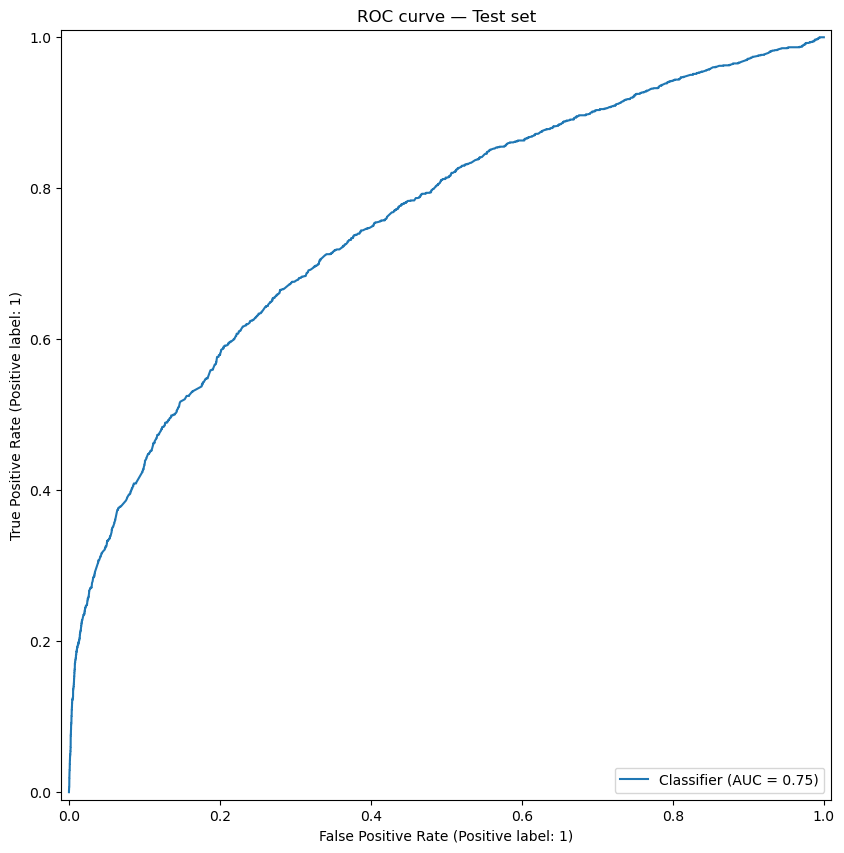

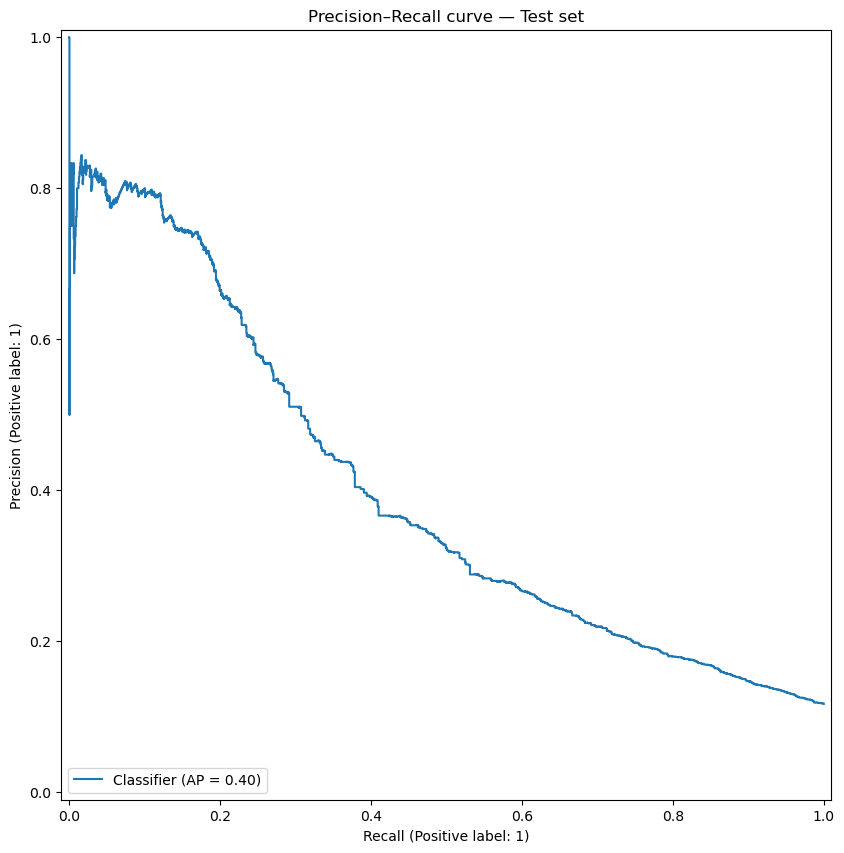

In [121]:
# performance curves

import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay

RocCurveDisplay.from_predictions(y_test, y_score)
plt.title("ROC curve — Test set")
plt.show()

PrecisionRecallDisplay.from_predictions(y_test, y_score)
plt.title("Precision–Recall curve — Test set")
plt.show()


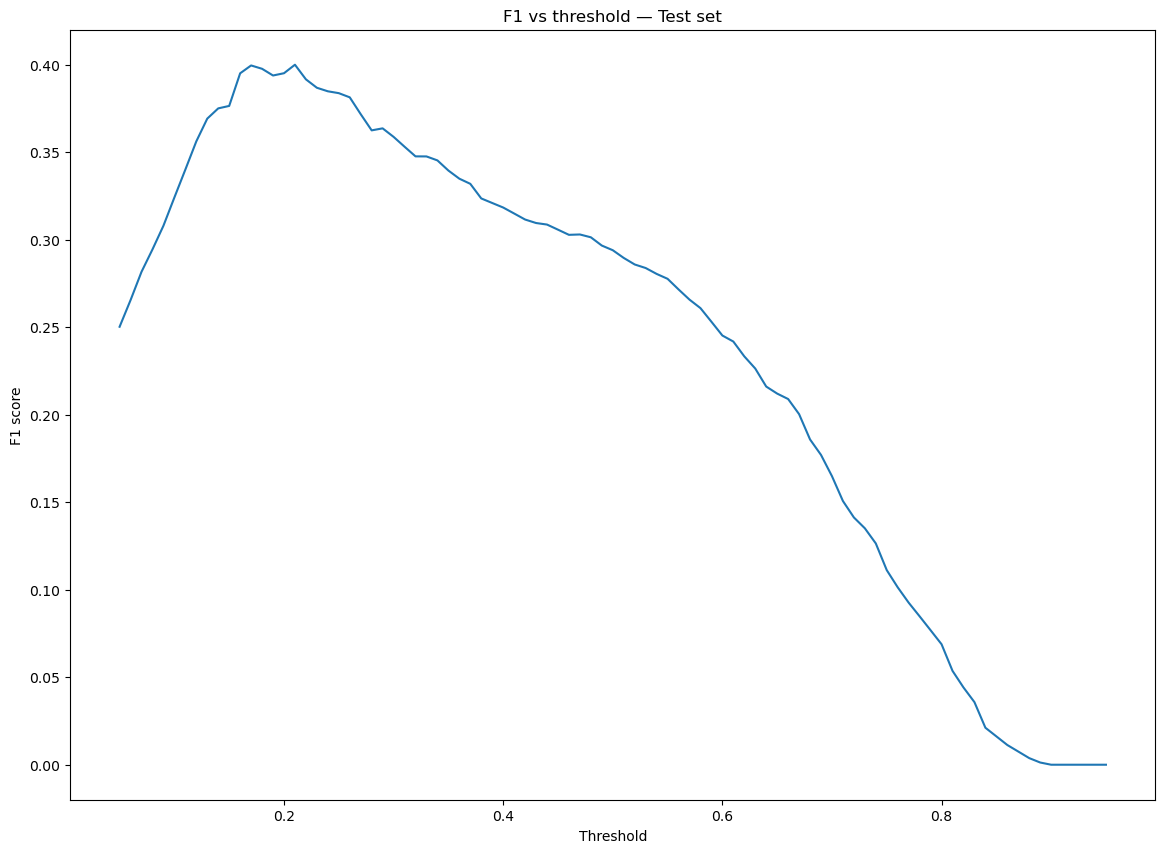

Best threshold for F1: 0.20999999999999996 Best F1: 0.4
Confusion matrix (best F1 threshold):
 [[11164   813]
 [  987   600]]


In [114]:
import numpy as np
from sklearn.metrics import f1_score

thresholds = np.linspace(0.05, 0.95, 91)
f1s = [f1_score(y_test, (y_score >= t).astype(int)) for t in thresholds]

plt.figure()
plt.plot(thresholds, f1s)
plt.xlabel("Threshold")
plt.ylabel("F1 score")
plt.title("F1 vs threshold — Test set")
plt.show()

best_t = thresholds[int(np.argmax(f1s))]
print("Best threshold for F1:", best_t, "Best F1:", max(f1s))

# Confusion matrix au meilleur seuil
y_pred_t = (y_score >= best_t).astype(int)
print("Confusion matrix (best F1 threshold):\n", confusion_matrix(y_test, y_pred_t))


Le modèle présente une capacité de discrimination correcte (ROC AUC ≈ 0.75).
Cependant, dans un contexte de forte déséquilibration, la courbe Precision–Recall montre que l’augmentation du rappel se fait au prix d’une baisse rapide de la précision.
L’analyse du F1 en fonction du seuil révèle que le seuil par défaut (0.5) n’est pas optimal ; un seuil plus bas (~0.2) permet un meilleur compromis précision–rappel, avec un F1 maximal proche de 0.40.

## Let's Conclude

Report your test set metrics for the three methods here

In [ ]:
# Decision Tree on test set

print(scores_table(scoresCLF42, model_name="Model Decision Tree, Seed = 42"))

--- Résultats pour le modèle : Model Decision Tree, Seed = 64 ---
Métrique   | Train    | Test
-----------------------------------------------------------------
Accuracy   |   0.8935 |   0.8924
Precision  |   0.6681 |   0.6513
Recall     |   0.1792 |   0.1730
F1 Score   |   0.2824 |   0.2733
ROC AUC    |   0.6815 |   0.6805
-----------------------------------------------------------------


In [116]:
# Random forest on test set
print(scores_table(scoresRCFBest, model_name="Model Random Forest, Seed = 42\n max_depth=11, n_estimators=300"))

--- Résultats pour le modèle : Model Random Forest, Seed = 42
 max_depth=11, n_estimators=300 ---
Métrique   | Train    | Test
-------------------------------------------------------------------------------------------------
Accuracy   |   0.8893 |   0.8887
Precision  |   0.7087 |   0.6952
Recall     |   0.0912 |   0.0851
F1 Score   |   0.1610 |   0.1511
ROC AUC    |   0.7756 |   0.7682
-------------------------------------------------------------------------------------------------


In [122]:
# XGBoost on test set
print(scores_table(scoresXGB, model_name="Model XGBoost, Seed = 42"))

--- Résultats pour le modèle : Model XGBoost, Seed = 42 ---
Métrique   | Train    | Test
-----------------------------------------------------------
Accuracy   |   0.8943 |   0.8943
Precision  |   0.6968 |   0.6963
Recall     |   0.1705 |   0.1713
F1 Score   |   0.2739 |   0.2748
ROC AUC    |   0.7553 |   0.7488
-----------------------------------------------------------


What do you notice? What are you real conclusion about the dataset? What should you tell the client about the dataset and his problem?

Il n'y a pas de trés grande différences entre les modèles 

- Accuracy ≈ 0.89 pour TOUS les modèles Decision Tree, Random Forest et XGBoost. Mais l’accuracy est inutile ici.
Elle est dominée par la classe majoritaire (~88 % de “no”).

Tous les modèles font à peine mieux qu’un DummyClassifier qui prédit toujours “no”.

- ROC AUC (stable mais plafonné) : Decision Tree : ~0.68, Random Forest : ~0.77, XGBoost : ~0.75            
Les modèles arrivent à trier les clients mieux que le hasard, mais aucun modèle ne dépasse franchement 0.78
Les gains entre modèles sont marginaux. 

- Recall très faible (≈ 0.08 – 0.17) : Random Forest : recall ≈ 0.085, Decision Tree / XGBoost : recall ≈ 0.17          
Les modèles ratent la majorité des “yes”, ils sont très conservateurs et  ne capturent qu’une petite fraction des clients réellement intéressés     

- Precision relativement élevée (~0.65–0.70)        
Quand le modèle dit “yes”, il a souvent raison
Mais il ose très rarement le dire


Comparaison globale des modèles
Modèle	        ROC AUC	Recall	   F1	Commentaire
Decision Tree	~0.68	~0.17	~0.27	Simple, sous-performe
Random Forest	~0.77	~0.09	~0.15	Bon ranking, très conservateur
XGBoost	~0.75	~0.17	~0.27	Meilleur compromis global

Ici XGBoost est le meilleur compromis, mais aucun modèle ne transforme radicalement le problème.

Le réel problème est que le dataset est très déséquilibré (≈ 11–12 % de “yes”)
Les variables disponibles avant l’appel sont :
- démographiques
- historiques
et sont contextuelles et faiblement discriminantes

Sans la variable duration (qui serait un data leakage), le pouvoir prédictif est naturellement limité.

Pour conclure les modèles testés montrent une capacité de discrimination correcte mais limitée (ROC AUC ≈ 0.75), principalement due à la forte déséquilibration et au faible signal prédictif des variables disponibles avant l’appel. Le modèle ne doit pas être utilisé comme un outil de décision binaire, mais comme un outil de priorisation des clients afin d’optimiser l’effort commercial. 

Ce que l'on peut dire au client :   
- Le problème n’est pas le modèle, mais la nature du problème et des données.       
- On ne peut pas prédire avec certitude qui va accepter     
- Les comportements clients sont peu déterministes
- Les variables disponibles avant contact sont insuffisantes
- Le modèle est utile comme outil de priorisation, pas de décision
- Il permet de classer les clients du plus au moins prometteur
- Ne pas utiliser l’accuracy comme indicateur principal (privilégier ROC AUC, Precision–Recall et les courbes de seuil).


- Write your memo about bagging and boosting method in a cell below.
- Which model would you choose for the bank, and why? Which precautions?

you can add your models result visualization in this cell if it helps you explaining your conclusions.

### Mémo : méthodes de Bagging et de Boosting

#### Bagging (Bootstrap Aggregating)

Le bagging consiste à entraîner plusieurs modèles indépendamment et en parallèle sur des échantillons bootstrap (tirages avec remise) du jeu d’entraînement, puis à agréger leurs prédictions (vote majoritaire ou moyenne des probabilités).

Le `Random Forest` est l’exemple le plus connu : il combine le bagging avec une sélection aléatoire des variables à chaque split afin de décorréler les arbres.

Les avantages du Bagging sont :
- Réduction de la variance des modèles instables (arbres de décision)              
- Bonne robustesse au bruit         
- Généralisation stable     
- Peu sensible au sur-apprentissage         
- Interprétation relativement simple (importance des variables)

Toutefois, comme chaque méthode, il ya des inconvénients :          
- N’améliore pas fondamentalement le biais du modèle            
- Peut plafonner lorsque le signal prédictif est faible     
- Tendance à être conservateur sur des cibles très déséquilibrées (recall faible)


#### Boosting

Le boosting entraîne les modèles de manière séquentielle. Chaque nouveau modèle se concentre davantage sur les observations mal prédites par les modèles précédents. Les algorithmes comme `Gradient Boosting ou XGBoost` ajustent progressivement les erreurs (résidus).

Avantages :     
- Réduction du biais        
- Très bon pouvoir de discrimination (AUC élevé)          
- capable de capter des relations complexes         
- Excellente performance en ranking     

Inconvénients :
- Plus sensible au bruit et aux outliers        
- Risque de sur-apprentissage si mal régularisé     
- Plus complexe à régler (beaucoup d’hyperparamètres)       
- Performances dépendantes du choix du seuil de décision        


#### Comparaison Basting / Boosting sur le dataset

Tous les modèles (Decision Tree, Random Forest, XGBoost) atteignent une accuracy élevée (~89%), mais celle-ci est peu informative en raison du fort déséquilibre de la cible.
Les performances en ROC AUC sont similaires et plafonnent autour de 0.75–0.77.
Le recall est faible pour tous les modèles, ce qui montre que la majorité des clients “yes” ne sont pas détectés.
Le Random Forest est très conservateur (précision élevée, recall très faible).
XGBoost offre le meilleur compromis global (AUC et F1 légèrement supérieurs), mais les gains restent limités.
Ces résultats indiquent que la limitation principale vient du dataset, et non du choix du modèle.

Le modèle recommandé est donc le XGBoost qui reste un bon outil de priorisation des clients (ranking), et est relativement plus flexible et performant que les modèles basés uniquement sur le bagging. 



## To go further

### Build a customized bagging classifier (Optional) 

- Use a different classification model you have seen until now and build a new classifier based on the [BaggingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html#sklearn.ensemble.BaggingClassifier) to create and train an new model.
- Use differents classification models and use the [VotingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html#sklearn.ensemble.VotingClassifier) to create and train a new model.

In [ ]:
# Write your code here

## Rebalance the data if you haven't done it yet

Before going through the modelling phase, let's see the label distribution :

Use the `value_counts` function and the appropriate visualization for displaying the label distribution

In [ ]:
# code here

What do you notice?

*answer here*

The easiest way to rebalance your data is to add the `class_weight='balanced'` parameter to your scikit learn model. The `class_weight` parameter is available in most scikit-learn models, for example look at the Decision Trees doc :
https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

(There are other techniques for rebalancing the data [here](https://blog.octo.com/donnees-desequilibrees-que-faire/), [here](https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/) and [here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html) ).

Rebalance the data with the `class_weight` parameter, and you'll have much better f1 and Average Precision metrics.

In [ ]:
# code here